## **Rapport de modélisation : Text mining**

## *Pré-requis : installations et import de modules*

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('all');

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
# installation des packages necessaires pour Word2vec
!pip install gensim
import gensim

In [ ]:
# installation des packages necessaires pour CamemBERT
!pip install transformers==4.29.0
!pip install sentencepiece
!pip install torch --upgrade
%reset -f

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [ ]:
pip show transformers

Name: transformers
Version: 4.29.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 


In [ ]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, make_scorer, classification_report, precision_score, recall_score, f1_score

from importlib.util import find_spec
import os
if find_spec("fasttext") is None:
  print("Module fasttext is unavailable - Proceeding to its installation")
  os.system("pip install fasttext")
import fasttext

Module fasttext is unavailable - Proceeding to its installation


## *Import des fichiers*

### *Point de montage et définition des répertoires utiles*

In [ ]:
# Open a session: initialize a few practical constants, mount share drive
from google.colab import drive
import os.path

DRIVE_PATH = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten"
CSV_FILE_DIR = os.path.join(DRIVE_PATH, "CSV_avec_traduction")
IMG_DIR = os.path.join(DRIVE_PATH, "train_test/images")
IMG_TRAIN_DIR = os.path.join(IMG_DIR, "image_train")

MODELS_DIR = os.path.join(DRIVE_PATH, "models")
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, "saved_models")
MODEL_RESULTS_DIR = os.path.join(MODELS_DIR, "model_results")

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### *Chargement des données (variables explicatives et cibles)*

In [ ]:
# Load train CSV files
df = pd.read_csv(os.path.join(CSV_FILE_DIR, "df_avec_traduction.csv"))

# Extraction of features
designations_descriptions = df['designe_decrit'].str.lower()

# Extraction of the target data
target_labels = df['Labels']
unique_categories = target_labels.drop_duplicates().sort_values()

## *Pré-traitement : mise en minuscules et retrait des mots-stops*

Certaines actions de pré processing sont nécessaires :

1.  **Gestion des minuscules** : conversion des données de descriptions en minuscules avant réalisation des actions de text mining
2.  **Retrait des stop words** : retrait des mots vides i.e. qui n'ont pas de sens pour notre analyse.

In [ ]:
from nltk.corpus import stopwords

designations_descriptions = df['designe_decrit'].str.lower()
stop = stopwords.words('french')
designations_descriptions = designations_descriptions.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

df["preprocessed_text"] = designations_descriptions

## *Découpage en données d'entraînement et données de test*

Ce découpage est effectué dès ici pour assurer une homogénéité dans l'ensemble du notebook

In [ ]:
def project_train_test_split(*data, stratify=None):
  if stratify is None:
    stratify = target_labels
  return train_test_split(
      *data, stratify=stratify, train_size=0.67, random_state=42
  )

In [ ]:
# Use stratified splitting as the target product categories are populated in quite an imbalanced fashion
df["preprocessed_text"] = designations_descriptions
df_train, df_test, y_train, y_test = project_train_test_split(df, target_labels)

# By default, train and test features are built from column "preprocessed_text" alone
X_train = df_train["preprocessed_text"]
X_test = df_test["preprocessed_text"]

### *Instanciation d'un vectorizer commun à différents modèles*

In [ ]:
vectorizer = TfidfVectorizer().fit(X_train)

## *Définition de fonctions d'affichage et d'analyse*

### *Affichage des scores d'un modèle en fonction de ses hyperparamètres*

In [ ]:
# Function to plot cross-validation grid search results
from sklearn.preprocessing import LabelEncoder

def plot_cvgrid_scores(
    grid,
    n_cols=3,
    cell_size=6,
    remove_one_val_params=True,
    train_test_diff=False,
    secondary_test_axis=False,
    equal_x_y_limits=False
):
  """
  Plot a grid search's score results. Several subplots will be produced, each with a scatter of the same data.
  The difference between the subplots will be that dots will be colored according to a different hyperparameter.
  The X axis of each subplot will represent the score or mean score obtained over test data.
  The Y axis content will depend of argument train_test_diff (see below).

  Arguments:
  grid (DataFrame): A DataFrame with columns:
                    - "mean_train_score" or "train_score"
                    - "mean_test_score" or "test_score"
                    - a series of columns named "param_<hyperparameter name>"
  n_cols (int, default = 3): Maximum number of subplots per row. New rows are created as necessary.
  cell_size (int, default = 6): Width and height of each subplot.
  remove_one_val_params (bool, default = True): When only one value is available for a given hyperparameter,
                                                discard it, i.e. do not add a subplot for it
  train_test_diff (bool, default = False): If True, plot the (mean) train minus to (mean) test score along the Y axis.
                                          If false, plot the (mean) test score along the Y axis and add
                                                    a dashed, black line to represent identity.
  secondary_test_axis (bool, default = False): If True, set a secondary X axis at the top of each scatter to represent
                                               the (mean) test score relative to the maximum of all plotted (mean) test scores.
  equal_x_y_limits (bool, default = False): If True, force X and Y ranges to be equal to each other.
                                            Mostly useful when train_test_diff = False.
  """
  train_scores = grid["mean_train_score"] if "mean_train_score" in grid.columns else grid["train_score"]
  test_scores = grid["mean_test_score"] if "mean_test_score" in grid.columns else grid["test_score"]

  if train_test_diff:
    y_axis_scores = train_scores - test_scores
    y_label = "Train - test score difference"
  else:
    y_axis_scores = train_scores
    y_label = "Train score"

  param_cols = sorted(c for c in grid.columns if c.startswith("param_"))
  if remove_one_val_params:
    param_cols = [c for c in param_cols if grid[c].drop_duplicates().count() > 1]

  param_names = [p[6:] for p in param_cols]
  n_params = len(param_names)

  n_rows = (n_params - 1) // n_cols + 1
  fig = plt.figure(figsize=(n_cols * cell_size, n_rows * cell_size))
  plt.subplots_adjust(bottom=-0.05, left=-0.05)
  i_fig = 0
  for param_col, param_name in zip(param_cols, param_names):
    i_fig += 1
    ax = fig.add_subplot(n_rows, n_cols, i_fig)

    param_values = grid[param_col]
    le = LabelEncoder()
    encoded_param_values = le.fit_transform(param_values)
    scatter = plt.scatter(test_scores, y_axis_scores, c=encoded_param_values, cmap=plt.cm.Spectral)

    if equal_x_y_limits:
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()
      xylim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
      ax.set_xlim(xylim)
      ax.set_ylim(xylim)

    if not train_test_diff:
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()
      xylim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
      ax.plot(xylim, xylim, ':k')
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)

    ax.set_xlabel("Test score")
    ax.set_ylabel(y_label)
    ax.set_title("Parameter '{}'".format(param_name))
    ax.legend(handles=scatter.legend_elements()[0], labels=le.classes_.tolist());

    if secondary_test_axis:
      ax2 = ax.twiny()
      ax2.set_xlim([x / test_scores.max() for x in ax.get_xlim()])
      ax2.set_xlabel("Relative to the maximum test score");


### *Affichage de différents scores par valeur-cible et par classificateur*

In [ ]:
# Plot scores for the different product categories and classifiers
def plot_scores_per_cat_mdl(ordered_categories, scores_per_cat_and_mdl, max_columns=3, cell_width=7.5, cell_height=5, kwargs_per_mdl=None):
  """
  Plot different scores per target category as obtained with several models. One subplot will be created for each score type,
  and the scores of the different models will be plotted in each of them.
  Arguments:
    ordered_categories: sequence of target categories
    scores_per_cat_and_mdl: dictionary of form {"score name": {"model name": [score for target 1, score for target 2...]}}.
                            The scores in each sequence must appear in the same order as items in ordered_categories
    max_columns: maximum subplot columns (defaults to 3)
    cell_width: width of each "cell"/subplot (defaults to 7.5)
    cell_height: height of each "cell"/subplot (defaults to 7.5)
    kwargs_per_mdl: if not None, a dictionary of form {"model name": {"pyplot.plot() kwarg name": value}}
  """
  n_scores = len(scores_per_cat_and_mdl)
  n_rows = 1 + (n_scores - 1) // max_columns
  n_columns = min(n_scores, max_columns)
  plt.figure(figsize=(cell_width * n_columns, cell_height * n_rows))

  if kwargs_per_mdl is None:
    kwargs_per_mdl = {}

  i_fig = 0
  for score_name, scores_per_mdl in scores_per_cat_and_mdl.items():
    i_fig += 1
    plt.subplot(n_rows, n_columns, i_fig)
    for mdl_name, score_per_cat in scores_per_mdl.items():
      plt.plot(ordered_categories, score_per_cat, label=mdl_name, **kwargs_per_mdl.get(mdl_name, {}))
    plt.xticks(rotation=90)
    plt.ylabel("{} score".format(score_name))
    plt.title("{} score per category and classifier".format(score_name))
    plt.legend()


### *Affichage de matrices de confusion*

In [ ]:
from matplotlib.colors import LogNorm

def plot_confusion_matrices(y_true, y_pred_per_mdl, ordered_categories=None, subplot_size=8, subplot_adjust_kwargs=None, sns_kwargs=None, log_scale=True, log_vmin=0.1, log_vmax=25e3):
  """
  Plot confusion matrices for different models. Plots will be vertically aligned.
  Arguments:
    y_true: true categories
    y_pred_per_mdl: dictionary of form {"model name": [predicted category 1, predicted category 2, ...]}
    ordered_categories: if provided, sequence of target categories in the desired display order. Otherwise, y_true will be used.
    subplot_size: size (width and height) of each subplot
    subplot_adjust_kwargs: kwargs to be passed to function pyplot.subplot_adjust. Defaults to {"bottom": -0.08}.
    sns_kwargs: if provided, will complete and/or override the following Seaborn display kwargs:
                - xticklabels = ordered_categories (or unique values in y_true)
                - yticklabels = ordered_categories (or unique values in y_true)
                - square = True
                - cbar_kws = {"shrink": 0.75}
                - cmap = plt.cm.plasma
                - log scale tuning (see following arguments)
    log_scale: if True, display the matrix in logarithmic scale. Defaults to True.
    log_vmin: if log_scale = True, minimum value to display. Defaults to 0.1.
    log_vmax: if log_scale = True, minimum value to display. Defaults to 25,000.
  """
  if ordered_categories is None:
    ordered_categories = np.unique(y_pred)

  kwargs = {
      "xticklabels": ordered_categories,
      "yticklabels": ordered_categories,
      "square": True,
      "cbar_kws": {"shrink": 0.75},
      "cmap": plt.cm.plasma,
  }
  if log_scale:
    kwargs["norm"] = LogNorm(vmin=log_vmin, vmax=log_vmax, clip=log_vmin)
  if sns_kwargs is not None:
    kwargs.update(sns_kwargs)

  if subplot_adjust_kwargs is None:
    subplot_adjust_kwargs = {"bottom": -0.08}

  n_subplots = len(y_pred_per_mdl)
  plt.figure(figsize=(subplot_size, subplot_size * n_subplots))
  plt.subplots_adjust(**subplot_adjust_kwargs)
  i_fig = 0
  for name, y_pred in y_pred_per_mdl.items():
    i_fig += 1
    plt.subplot(n_subplots, 1, i_fig)
    cm = confusion_matrix(y_true, y_pred, labels=ordered_categories)
    sns.heatmap(cm, **kwargs)
    plt.xlabel("Predicted categories")
    plt.ylabel("True categories")
    plt.title("Model = {}".format(name));


## *Essai de différents classificateurs (modélisation "classique")*

### *Essai simple et "naïf" de quelques classificateurs avec leurs paramètres par défaut*

In [ ]:
# Try different algorithms, each with its default hyperparameters
# Now, try the models. Use all possible tokens when models accept it, otherwise use a limited number of tokens.
clf_metrics = {}
train_test_tokens = {}

sgd = SGDClassifier(class_weight="balanced")
knn = KNeighborsClassifier()
rf = RandomForestClassifier(class_weight="balanced")
for name, clf, max_tokens, use_dense in (
    ("SGD", sgd, None, False),
    ("KNN", knn, 20000, True), # With too many tokens, sparse matrix makes KNN slow and dense matrix makes it use too much RAM
    ("RF", rf, None, False)
):
    print("{} - Try model '{}'".format(time.strftime("%Y-%m-%d %H:%M:%S"), name))

    if max_tokens not in train_test_tokens:
      vectorizer = TfidfVectorizer(max_features=max_tokens)
      train_test_tokens[max_tokens] = (vectorizer.fit_transform(X_train), vectorizer.transform(X_test))

    tokens_train, tokens_test = train_test_tokens[max_tokens]

    clf_metrics[name] = {"token_count": tokens_train.shape[1]}

    if use_dense:
      tokens_train = tokens_train.toarray()
      tokens_test = tokens_test.toarray()

    started_at = time.time()

    clf.fit(tokens_train, y_train)
    fit_at = time.time()
    clf_metrics[name]["fitting_duration"] = fit_at - started_at

    clf_metrics[name].update({
        "train_score": balanced_accuracy_score(y_train, clf.predict(tokens_train)),
        "test_score": balanced_accuracy_score(y_test, clf.predict(tokens_test)),
    })
    clf_metrics[name]["scoring_duration"] = time.time() - fit_at

    print("{} - Model results = {}".format(
        time.strftime("%Y-%m-%d %H:%M:%S"),
        {
            k: round(v, 3) if isinstance(v, float) else v
            for k, v in clf_metrics[name].items()
        }
    ))


2023-07-05 17:45:21 - Try model 'SGD'
2023-07-05 17:45:35 - Model results = {'token_count': 148214, 'fitting_duration': 6.792, 'train_score': 0.886, 'test_score': 0.773, 'scoring_duration': 0.61}
2023-07-05 17:45:35 - Try model 'KNN'
2023-07-05 19:51:04 - Model results = {'token_count': 20000, 'fitting_duration': 2.564, 'train_score': 0.656, 'test_score': 0.454, 'scoring_duration': 7496.003}
2023-07-05 19:51:04 - Try model 'RF'
2023-07-05 20:09:31 - Model results = {'token_count': 148214, 'fitting_duration': 1089.787, 'train_score': 1.0, 'test_score': 0.745, 'scoring_duration': 16.961}


Un test simple de 3 classificateurs, sans ajustement des hyperparamètres, donne des résultats mitigés :

*   Score de test de 77% dans le meilleur des cas, avec un Stochastic Gradient Descent classifier. Ce classificateur est en surapprentissage puisque le score d'entraînement est de 88%
*   Score de test de 75% avec un Random Forest Classifier. Avec un score d'entraînement de presque 100%, le suraprentissage est flagrant
*   Le K-Nearest-Neighbor Classifier est le plus décevant. Non seulement a-t-il fallu réduire le nombre de tokens fournis à son entrée pour parvenir à le lancer, mais en plus il donne le pire score de test (44%) et il est lui aussi en situation de suraprentissage (score d'entraînement de 61%)

### *Exploration TF-IDF avec KNN : tokenisation avec un nombre max de features*

Plusieurs algorithmes d’apprentissage peuvent être utilisés pour la classification automatique de textes : méthode des K plus proches voisins, arbres de décision, SVM, forêts aléatoires.
Il s’agit d’évaluer l’algorithme d’apprentissage qui mettra en place le meilleur modèle. Le modèle est celui qui va définir les critères d’appartenances d’un texte à une ou plusieurs catégories.

**TOKENISATION :** Une tokenisation des données de texte (description des produits) est d'abord nécessaire avant d'évaluer un algorithme. La méthode  TF-IDF (de l'anglais term frequency-inverse document frequency) est une méthode de pondération qui permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [ ]:
# Import des bibliothèques et fonctions nécessaires pour les cellules suivantes
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

max_words = 70000
kn_n_estimators = (3, 5)

rf_result_df = pd.DataFrame(columns=["n_estimators", "n_words", "duration", "train_score", "test_score"])

# Tokenisation avec un nombre max de mots
print("[{}] Max words = {} - Start tokenizing".format(datetime.datetime.now(), max_words))
vectorizer = TfidfVectorizer(max_features=max_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Démarrage du traitement en testant les n estimateurs
for n_estimators in kn_n_estimators:
  start_at = datetime.datetime.now().timestamp()

  clf_kn=KNeighborsClassifier(
          n_neighbors=n_estimators,
          metric="minkowski"
  )
  print("[{}] KNN estimators = {}, Max words = {} - Start KNN fitting".format(datetime.datetime.now(), n_estimators, max_words))
  clf_kn.fit(X_train, y_train)
  y_pred=clf_kn.predict(X_train)
  y_pred_test=clf_kn.predict(X_test)
  train_score = balanced_accuracy_score(y_train, y_pred)
  test_score = balanced_accuracy_score(y_test, y_pred_test)
  duration = datetime.datetime.now().timestamp() - start_at

  # affichage du taux de bonnes prédictions sur données d’entrainement et de test
  cr2=classification_report(y_test, y_pred_test)

  print(
        "[{}] KNN estimators = {}, Max words = {} - Duration = {}, Train score = {} & test score = {}".format(
            datetime.datetime.now(), n_estimators, max_words, duration, train_score, test_score
        )
  )
  #print(cr1)
  print(cr2)

  rf_result_df.loc[len(rf_result_df)] = {
      "n_estimators": n_estimators,
      "n_words": X_train.shape[1],
      "duration": duration,
      "train_score": train_score,
      "test_score": test_score,
  }


[2023-05-15 08:02:12.425603] Max words = 70000 - Start tokenizing
[2023-05-15 08:02:18.754738] KNN estimators = 3, Max words = 70000 - Start KNN fitting
[2023-05-15 10:45:55.098540] KNN estimators = 3, Max words = 70000 - Duration = 9815.626774072647, Train score = 0.8255804815967961 & test score = 0.4299637243065601
                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.63      0.63      0.63       355
              Accessoires enfants       0.97      0.86      0.91       202
       Accessoires piscine et spa       0.99      0.82      0.90      2552
                     Alimentation       0.96      0.42      0.59       201
                       Animalerie       0.97      0.31      0.46       206
      Archives journaux et presse       0.50      0.08      0.13      1190
             Bricolage, jardinage       0.88      0.46      0.61       624
                Cartes à échanger       0.93      0.63      0.75       988
     

In [ ]:
# Save random forest results
rf_result_df.to_csv(os.path.join(DRIVE_PATH, "Luc/text_mining_KNN_results.csv"))

### *Exploration du modèle Random Forest*

#### *Première grille d'hyperparamètres*

##### *Calcul*

In [ ]:
# Try random forest with different parameters
rf_param_grid = {
    "max_depth": (20, 50, 100, 200),
    "max_features": (20, 50, 100, 200),
    "min_samples_leaf": (1, 2, 5, 10),
}

rf_clf = RandomForestClassifier(
    criterion="gini",
    n_estimators=50,
    random_state=22,
    class_weight="balanced"
)
rf_pipeline = Pipeline((
    ("tokenizer", TfidfVectorizer()),
    ("random_forest", rf_clf)
))

skf = StratifiedKFold(n_splits=3, random_state=37, shuffle=True)

param_grid = {"random_forest__" + k: v for k, v in rf_param_grid.items()}
grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf,
    verbose=3,
    refit=False,
    return_train_score=True
)
grid_rf.fit(designations_descriptions, target_labels)

grid_rf_result_df = pd.DataFrame(grid_rf.cv_results_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=1;, score=(train=0.463, test=0.399) total time=  11.7s
[CV 2/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=1;, score=(train=0.437, test=0.374) total time=   8.7s
[CV 3/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=1;, score=(train=0.446, test=0.379) total time=   9.7s
[CV 1/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=2;, score=(train=0.406, test=0.387) total time=   6.1s
[CV 2/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=2;, score=(train=0.386, test=0.368) total time=   6.2s
[CV 3/3] END random_forest__max_depth=20, random_forest__max_features=20, random_forest__min_samples_leaf=2;, score=(train=0.386, tes

In [ ]:
# Save results of grid search into a CSV file - Please replace YYYYMMDD with the current date or any other versioning suffix
# grid_rf_result_df.to_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_grid_random_forest_results_20230505.csv"))

##### *Analyse*

In [ ]:
# Reload grid search results - Please mind the version suffix (should be a date in YYYYMMDD format)
# grid_rf_result_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_grid_random_forest_results_20230505.csv"))

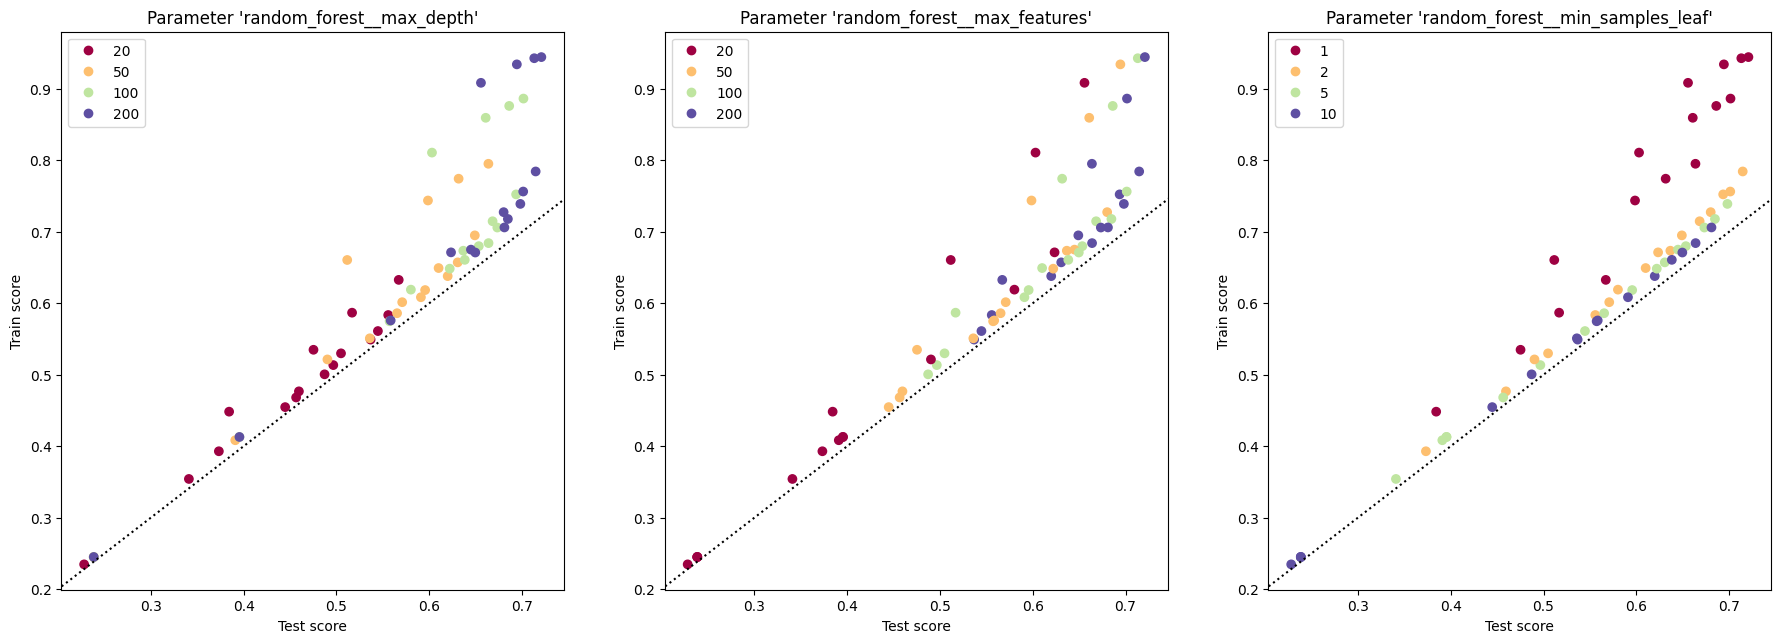

In [ ]:
# Plot random forest hyperparameter exploration results
plot_cvgrid_scores(grid_rf_result_df, train_test_diff=False)


Dans un premier temps, nous avons joué sur 3 hyperparamètres des Random Forest Classifiers :

*   `max_depth` : profondeur maximale de chacun des arbres
*   `max_features` : nombre maximal de variables à prendre en compte pour estimer le meilleur moment pour diviser un noeud dans un arbre
*   `min_samples_leaf` : nombre minimum d'observations par feuille dans un arbre

Les graphes ci-dessus montrent les choses suivantes :

*   Il est impératif de fournir une valeur suffisamment haute au paramètre `min_samples_leaf`. Une valeur de 1 aboutit tantôt à des scores de test faibles, tantôt à un suraprentissage flagrant. Une valeur de 2 tend elle aussi à provoquer un suraprentissage, du moins comparé avec les valeurs 5 et 10. La différence de résultat entre ces deux dernières est minime. Nous retenons une valeur de 5 comme compromis entre score de test et limitation du suraprentissage.
*   Si nous nous limitons au cas où le suraprentissage reste modéré (`min_samples_leaf` d'au moins 2), une valeur plus grande `max_depth` aboutit à de meilleurs scores de test sans effet majeur sur le suraprentissage. Les résultats sont meilleurs avec `max_depth` = 100 ou 200. Il est probable qu'une valeur encore plus importante aurait amélioré les résultats, mais à la marge seulement et en augmentant sensiblement les temps de calcul. Nous retiendrons une valeur de 200.
*   L'influence de `max_features` est peu claire sur le graphe. Inspectons le résultat en fixant `min_samples_leaf` à 5 et `max_depth` à 200.

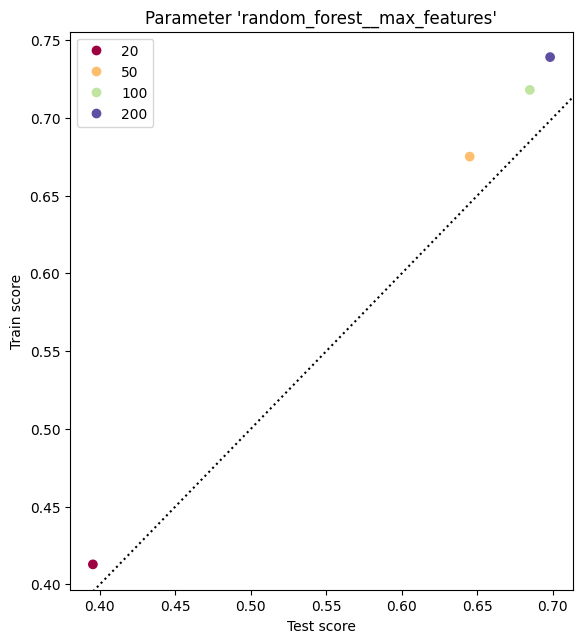

In [ ]:
# Plot random forest hyperparameter exploration results: focus on "max_depth" alone
plot_cvgrid_scores(grid_rf_result_df[
    (grid_rf_result_df["param_random_forest__min_samples_leaf"] == 5)
    & (grid_rf_result_df["param_random_forest__max_depth"] == 200)
])

Nous pouvons constater qu'à partir de 50, l'impact de la valeur de `max_features` est minime. Nous retiendrons une valeur 100 qui indique un score de test et un effet de suraprentissage intermédiaires.

Reste à tester quelques hyperparamètres qui feront l'objet d'une exploration ci-dessous :

*   Le critère à optimiser (paramètre `criterion`)
*   Le nombre d'estimateurs, ou arbres (paramètre `n_estimators`)
*   Un paramètre propre à la tokenisation et qui fournit le nombre maximal de tokens à produire lors de la vectorisation (paramètre `max_features` du vectoriseur). Ce paramètre peut être vu comme outil de réduction de dimensions.

#### *Seconde grille de paramètres*

##### *Calcul*

In [ ]:
# 2nd random forest exploration, with other parameters
max_tokens = (10000, 20000, 50000, None)
rf_param_grid_2 = {
    "criterion": ("gini", "entropy", "log_loss"),
    "n_estimators": (50, 100, 200, 500)
}

rf_clf_2 = RandomForestClassifier(
    max_depth=200,
    min_samples_leaf=5,
    max_features=100,
    random_state=22,
    class_weight="balanced"
)
rf_pipeline_2 = Pipeline((
    ("tokenizer", TfidfVectorizer()),
    ("random_forest", rf_clf_2)
))

skf_2 = StratifiedKFold(n_splits=3, random_state=37, shuffle=True)

param_grid_2 = {"random_forest__" + k: v for k, v in rf_param_grid_2.items()}
param_grid_2["tokenizer__max_features"] = max_tokens
grid_rf_2 = GridSearchCV(
    estimator=rf_pipeline_2,
    param_grid=param_grid_2,
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf_2,
    verbose=3,
    refit=False,
    return_train_score=True
)
grid_rf_2.fit(designations_descriptions, target_labels)

grid_rf_result_df_2 = pd.DataFrame(grid_rf_2.cv_results_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=10000;, score=(train=0.766, test=0.705) total time=  25.6s
[CV 2/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=10000;, score=(train=0.767, test=0.706) total time=  25.4s
[CV 3/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=10000;, score=(train=0.764, test=0.708) total time=  25.2s
[CV 1/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=20000;, score=(train=0.759, test=0.705) total time=  16.5s
[CV 2/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=20000;, score=(train=0.758, test=0.708) total time=  16.9s
[CV 3/3] END random_forest__criterion=gini, random_forest__n_estimators=50, tokenizer__max_features=20000;, score=(train=0.760, test=0.710) tot

In [ ]:
# Save results of grid search into a CSV file - Please replace YYYYMMDD with the current date or any other versioning suffix
# grid_rf_result_df_2.to_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_grid_random_forest_2_results_YYYYMMDD.csv"))

##### *Analyse*

In [ ]:
# Reload grid search results - Please mind the version suffix (should be a date in YYYYMMDD format)
# grid_rf_2_result_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_grid_random_forest_2_results_20230505.csv"))

# Some help needed: column param_tokenizer__max_features is detected as float instead of int, probably because of the None value we assessed
# import numpy as np
# grid_rf_2_result_df["param_tokenizer__max_features"] = grid_rf_2_result_df["param_tokenizer__max_features"].apply(lambda n: str(int(n)) if not np.isnan(n) else "None")

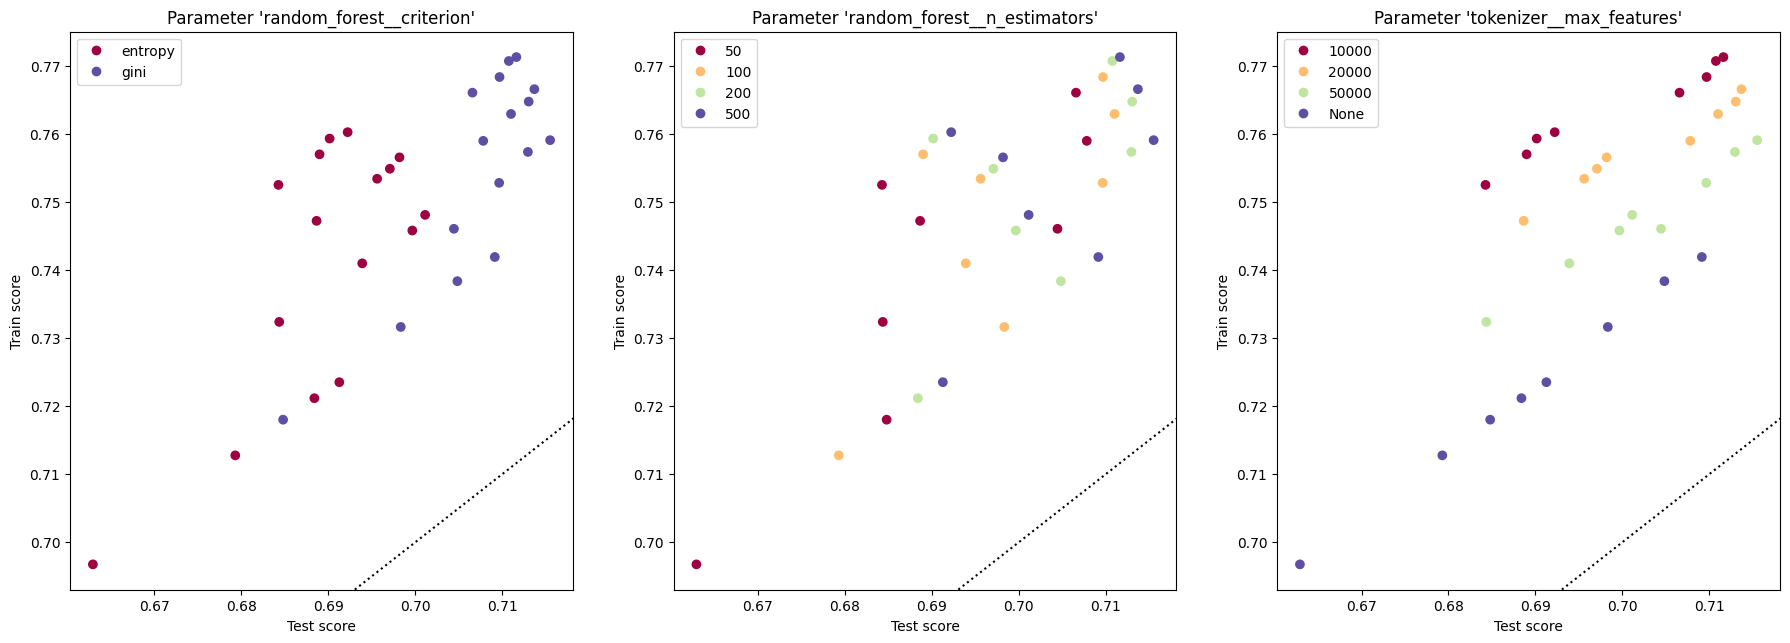

In [ ]:
# Plot 2nd random forest hyperparameter exploration results
# Note: results for criteria "entropy" and "log_loss" are fully overlapped. Let's discard "log_loss".
plot_cvgrid_scores(grid_rf_2_result_df[grid_rf_2_result_df["param_random_forest__criterion"] != "log_loss"])

Cette seconde exploration des classificateurs Random Forest montre ceci :

*   Il n'y a que peu voire pas d'intérêt à limiter le nombre de tokens générés lors de la vectorisation TF-IDF. Au mieux, une limitation à 50 000 tokens améliorera très légèrement le score de test. Dans tous les cas, une limitation du nombre de tokens est source de suraprentissage, et ce d'autant plus que le nombre de tokens est petit. Ajoutons qu'elle augmente aussi les temps de calcul.
*   Les critères "entropie" et "log-loss" donnent des résultats identiques et moins satisfaisants que ceux du critère de Gini. C'est donc ce dernier que nous conserverons.
*   Augmenter le nombre d'arbres (estimateurs) améliore très légèrement les résultats tout en augmentant les temps de calcul. Il est probable qu'un nombre d'estimateur fixé à 100 ou 200 soit la meilleure solution.

In [ ]:
# Check result stability: 2nd random forest exploration, only criterion equal to "gini" and unlimited token count
grid_rf_to_check = grid_rf_2_result_df
grid_rf_to_check = grid_rf_to_check.loc[
    (grid_rf_to_check["param_random_forest__criterion"] == "gini")
    & (grid_rf_to_check["param_tokenizer__max_features"].isna())
]

grid_rf_to_check[["param_random_forest__n_estimators", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].sort_values("param_random_forest__n_estimators")

#### *Bilan*

Pour finir avec les classificateurs Random Forest, plus le nombre d'arbres/estimateurs est élevé, plus la dispersion des scores aussi bien de test que d'entraînement est importante.

Dans l'ensemble, nous retenons les hyperparamètres suivants :

*   `n_estimators = 100`
*   `criterion = "gini"`
*   `max_depth = 200`
*   `max_features = 100`
*   `min_samples_leaf = 5`

De plus, nous décourageons la limitation du nombre de tokens générés par la vectorisation des textes.

Avec ce jeu d'hyperparamètres, la validation croisée donne une accuracy pondérée de 73% en entraînement et 70% en test.

### *Exploration du modèle Stochastic Gradient Descent*

#### *Calcul*

In [ ]:
# Try stochastic gradient descent with different parameters
sgd_param_grid = {
    "alpha": (0.0001, 0.0002, 0.0005, 0.001),
    "l1_ratio": (0., 0.2, 0.4, 0.6, 0.8, 1.),
    "loss": ("hinge", "log_loss", "huber", "perceptron"),
}

sgd_clf = SGDClassifier(
    penalty="elasticnet",
    random_state=22,
    class_weight="balanced"
)
sgd_pipeline = Pipeline((
    ("tokenizer", TfidfVectorizer()),
    ("sgd", sgd_clf)
))

skf = StratifiedKFold(n_splits=3, random_state=37, shuffle=True)

param_grid = {"sgd__" + k: v for k, v in sgd_param_grid.items()}
grid_sgd = GridSearchCV(
    estimator=sgd_pipeline,
    param_grid=param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf,
    verbose=3,
    refit=False,
    return_train_score=True
)
grid_sgd.fit(designations_descriptions, target_labels)

grid_sgd_result_df = pd.DataFrame(grid_sgd.cv_results_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=hinge;, score=(train=0.888, test=0.773) total time=  25.7s
[CV 2/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=hinge;, score=(train=0.887, test=0.772) total time=  24.3s
[CV 3/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=hinge;, score=(train=0.888, test=0.775) total time=  22.7s
[CV 1/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=log_loss;, score=(train=0.784, test=0.733) total time=  21.7s
[CV 2/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=log_loss;, score=(train=0.785, test=0.737) total time=  24.0s
[CV 3/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=log_loss;, score=(train=0.783, test=0.738) total time=  26.7s
[CV 1/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=huber;, score=(train=0.776, test=0.709) total time=  21.1s
[CV 2/3] END sgd__alpha=0.0001, sgd__l1_ratio=0.0, sgd__loss=huber;, score=(train=0.775, 

In [ ]:
# Save results of grid search into a CSV file - Please replace YYYYMMDD with the current date or any other versioning suffix
# grid_sgd_result_df.to_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_sgd_results_20230508.csv"))

#### *Analyse*

In [ ]:
# Reload grid search results - Please mind the version suffix (should be a date in YYYYMMDD format)
# grid_sgd_result_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "text_mining_sgd_results_20230508.csv"))

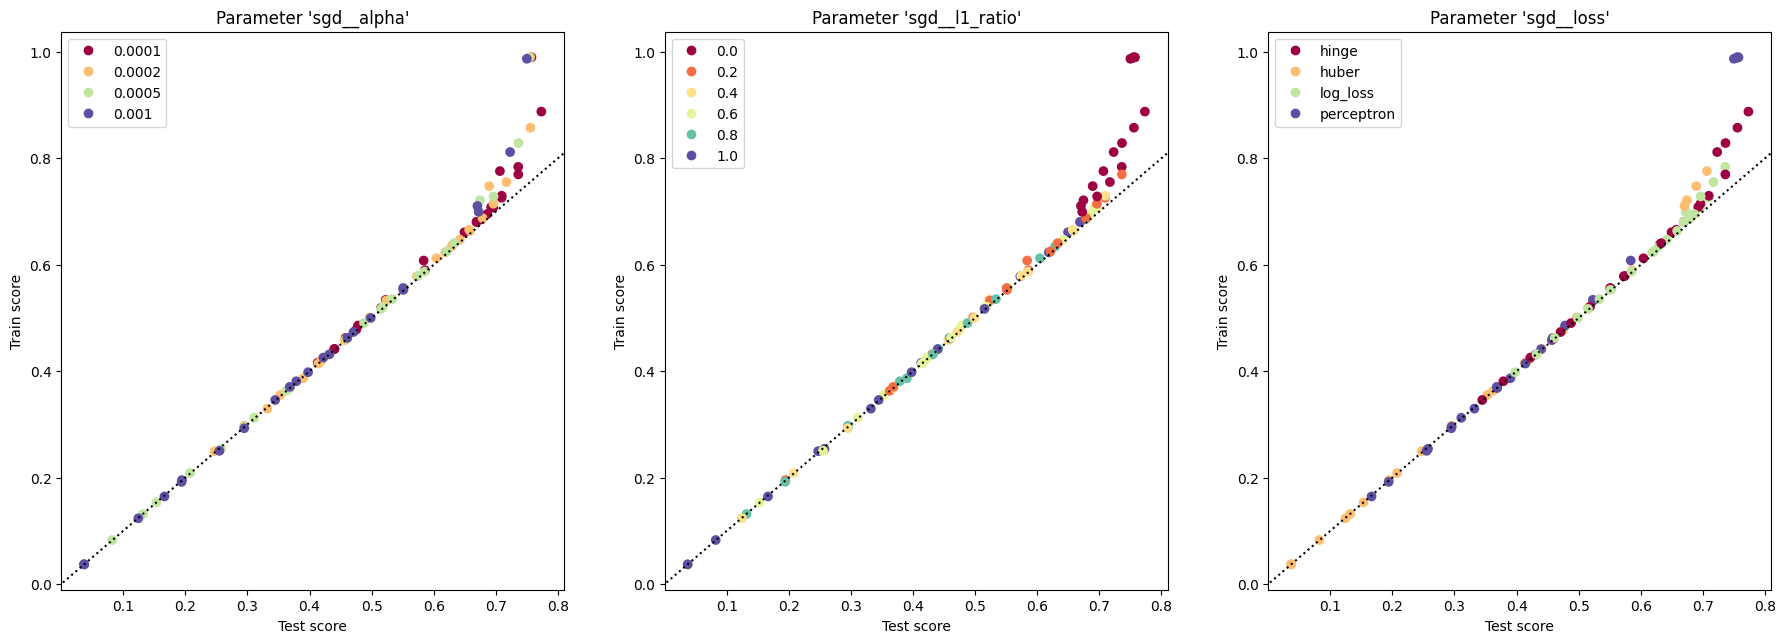

In [ ]:
plot_cvgrid_scores(grid_sgd_result_df)

Les graphes ci-dessus montrent l'influence des paramètres suivants sur la capacité de Stochastic Gradient Descent classifiers à s'entraîner sur notre jeu de données :

*   `alpha` : terme de régularisation. Une valeur plus grande se traduit par une régularisation plus forte.
*   `l1_ratio` : nous avons opté pour une pénalisation de type Elastic Net, qui "combine" les pénalisations l1 et l2. `l1_ratio` est un coefficient pouvant varier de 0 pour une pénalisation purement de type l2 à 1 pour une pénalisation exclusivement l1.
*   `loss` : fonction de perte à utiliser.

La lecture des graphes s'avère plus difficile que pour les classificateurs Random Forest. Le seul paramètre dont la variation est rapide à interpréter est `l1_ratio` : une valeur nulle est à exclure car elle conduit à un suraprentissage important. On constate aussi une grande variété de scores de test qui pourra être mieux analysée en excluant les modèles avec `l1_ratio` nul.

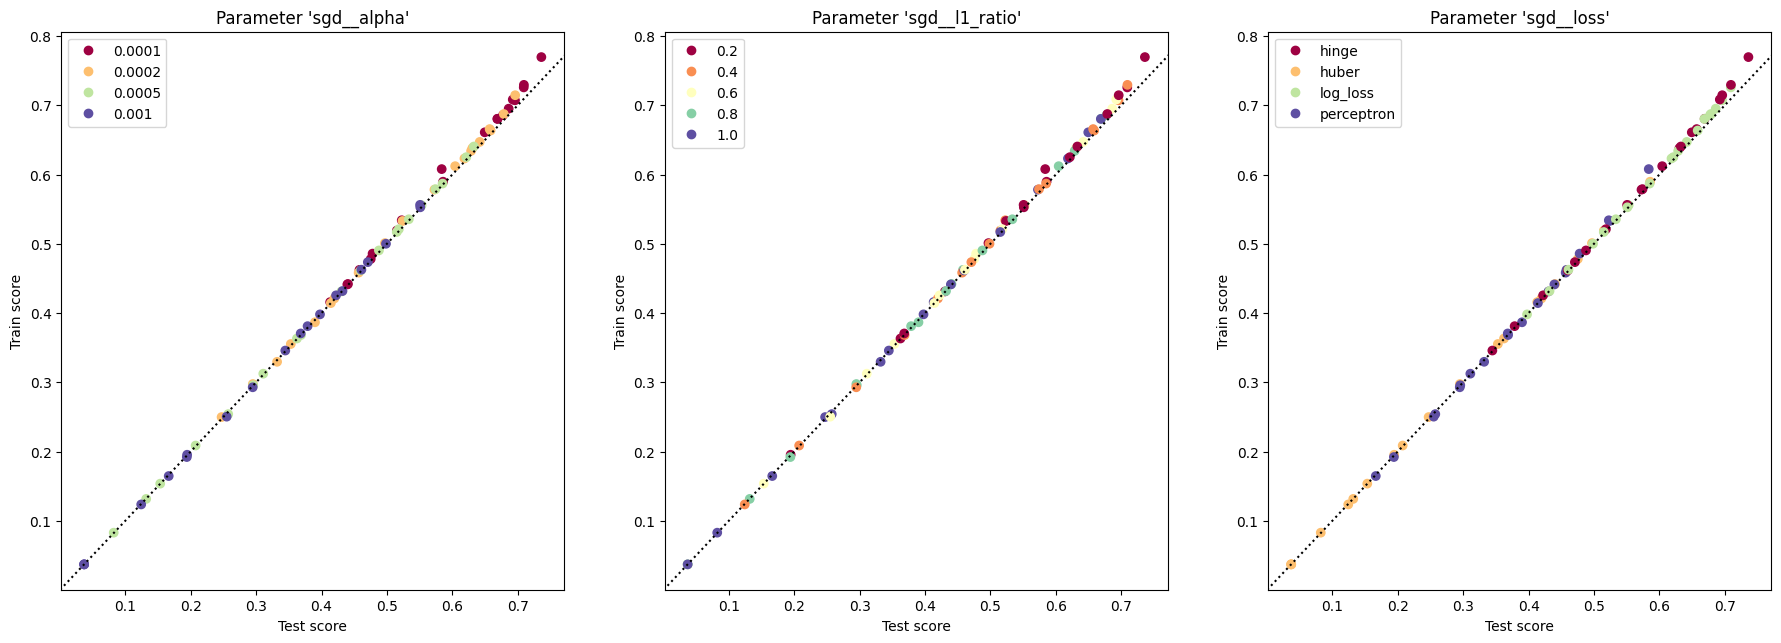

In [ ]:
plot_cvgrid_scores(grid_sgd_result_df
  [
      grid_sgd_result_df["param_sgd__l1_ratio"] > 0.
  ]
)

L'exclusion du cas `l1_ratio = 0` ne laisse plus que des modèles à faible suraprentissage. Néanmoins, les scores sont loin de toujours être satisfaisants. C'est le cas notament avec les fonctions de perte "Huber" et "Perceptron", que nous excluons donc.

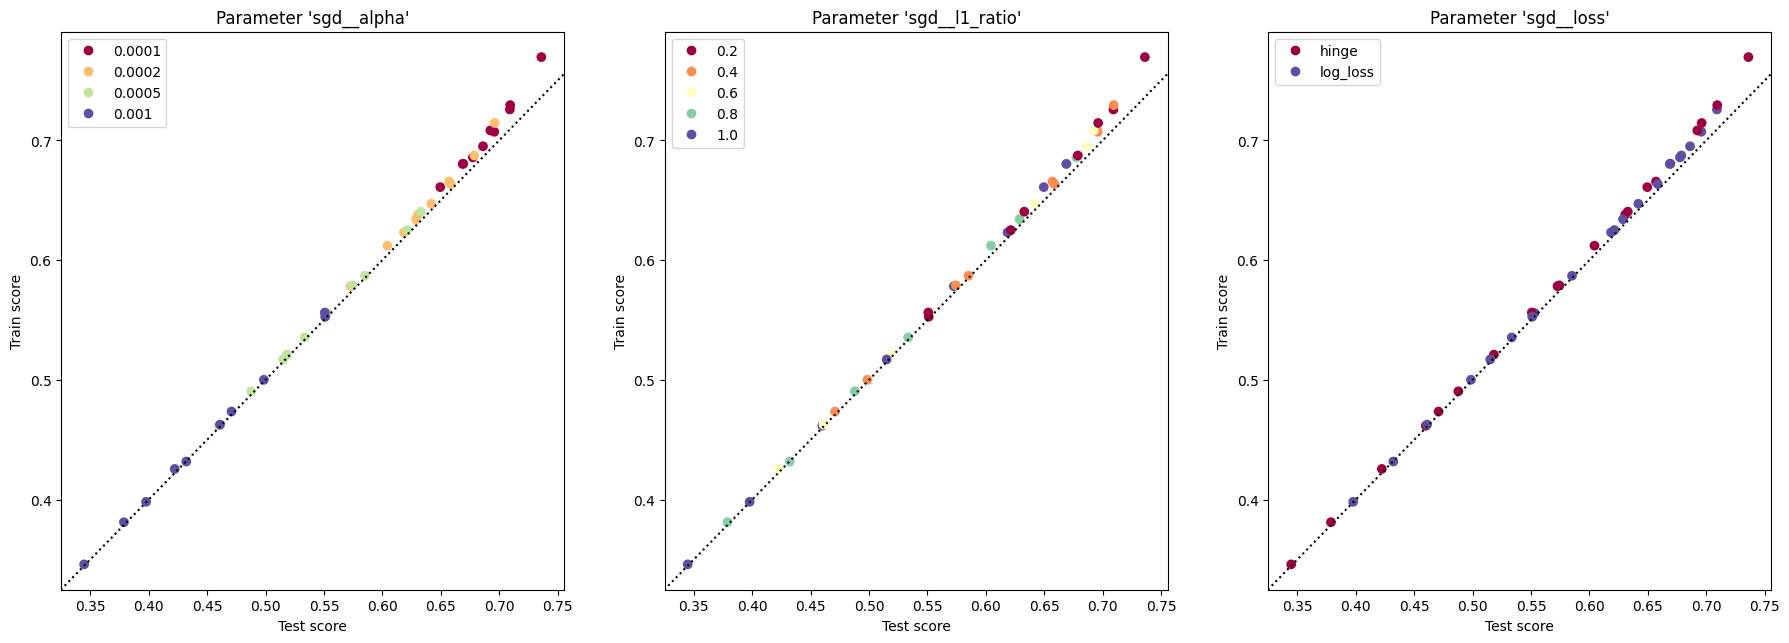

In [ ]:
plot_cvgrid_scores(grid_sgd_result_df
  [
      (grid_sgd_result_df["param_sgd__l1_ratio"] > 0.)
      & (grid_sgd_result_df["param_sgd__loss"].isin(["hinge", "log_loss"]))
  ]
)

Nous pouvons désormais aussi écarter les valeurs trop grandes du coefficient $\alpha$ de régularisation, supérieurs ou égaux à 0.005, qui aboutissent à de faibles scores par comparaison aux autres valeurs du paramètres.

Par ailleurs, nous pouvons observer des "enveloppes" séparées formées par les valeurs "hinge" et "log_loss" pour la fonction de perte. Il apparaît clairement que la valeur "log_loss" aboutit à un moindre suraprentissage et c'est donc elle que nous retiendrons.

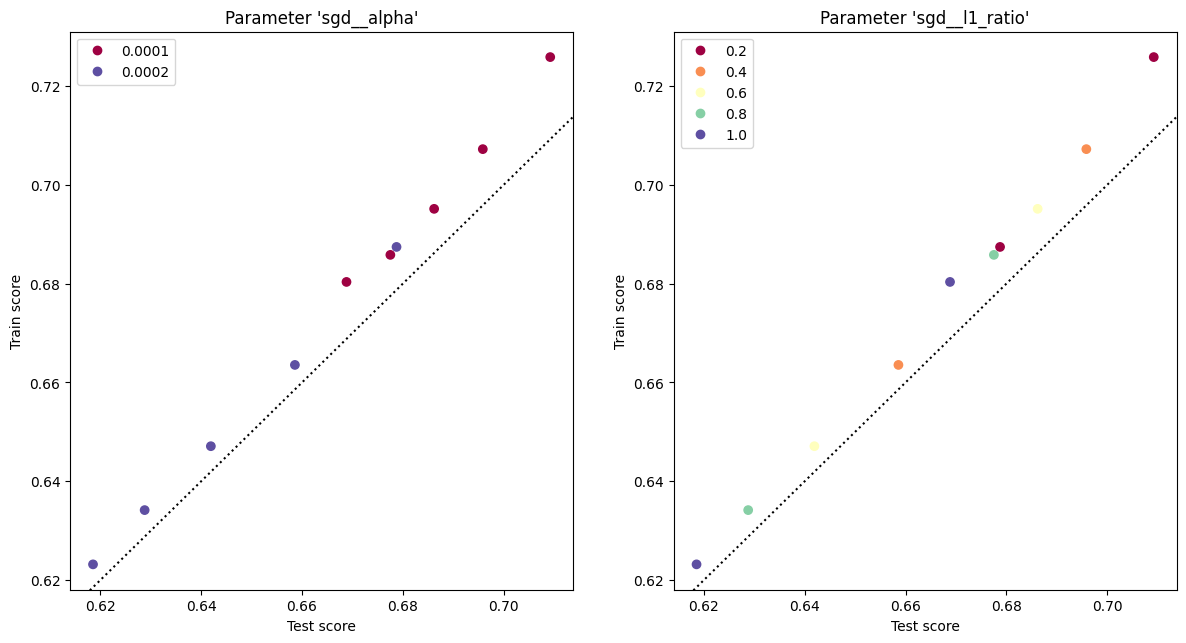

In [ ]:
plot_cvgrid_scores(grid_sgd_result_df
  [
      (grid_sgd_result_df["param_sgd__l1_ratio"] > 0.)
      & (grid_sgd_result_df["param_sgd__loss"] == "log_loss")
      & (grid_sgd_result_df["param_sgd__alpha"] < 0.0005)
  ]
)

Parmi les valeurs d'hyperparamètres encore en jeu, il devient difficile de trancher sur la seule base des graphes présentés. Il reste quatre combinaisons de valeurs potentiellement intéressantes :

*   $\alpha = 0.0001$, `l1_ratio = 0.4`
*   $\alpha = 0.0001$, `l1_ratio = 0.6`
*   $\alpha = 0.0001$, `l1_ratio = 0.8`
*   $\alpha = 0.0002$, `l1_ratio = 0.2`

Un examen des dispersions des scores obtenus par validation croisée permettra peut-être de trancher entre ces possibilités.

In [ ]:
grid_sgd_result_df[
    (grid_sgd_result_df["param_sgd__loss"] == "log_loss")
    & (
      (
          (grid_sgd_result_df["param_sgd__alpha"] == 0.0001)
          & (grid_sgd_result_df["param_sgd__l1_ratio"].isin([0.4, 0.6, 0.8]))
      )
      | (
          (grid_sgd_result_df["param_sgd__alpha"] == 0.0002)
          & (grid_sgd_result_df["param_sgd__l1_ratio"] == 0.2)
      )
    )
][
    ["param_sgd__alpha", "param_sgd__l1_ratio", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]
].sort_values("std_test_score")

,param_sgd__alpha,param_sgd__l1_ratio,mean_train_score,std_train_score,mean_test_score,std_test_score
17,0.0001,0.8,0.685816,0.001468,0.677514,0.001167
9,0.0001,0.4,0.707220,0.000537,0.695849,0.001993
29,0.0002,0.2,0.687425,0.000752,0.678737,0.002279
13,0.0001,0.6,0.695134,0.001129,0.686197,0.002516


#### *Bilan*

La dispersion des scores est clairement moindre pour l'une des quatre combinaisons que pour les trois autres. Nous retiendrons finalement les hyperparamètres suivants :

*   `alpha = 0.0001`
*   `l1_ratio = 0.8`
*   `loss = "log_loss"`

## *Performances des classificateurs "classiques" sur les différentes catégories de produits*

### *Vectorisation des textes d'entraînement et de test*

In [ ]:
vectorizer = TfidfVectorizer()
tokens_train = vectorizer.fit_transform(X_train)
tokens_test = vectorizer.transform(X_test)

### *Entraînement des modèles*

In [ ]:
# Instantiate models

rf_clf = RandomForestClassifier(
    class_weight="balanced",
    random_state=37,
    n_estimators=100,
    criterion="gini",
    max_depth=200,
    max_features=100,
    min_samples_leaf=5
)

sgd_clf = SGDClassifier(
    class_weight="balanced",
    random_state=53,
    alpha=0.0001,
    l1_ratio=0.8,
    loss="log_loss"
)

names_and_clf = (("RF", rf_clf), ("SGD", sgd_clf))

In [ ]:
# Train models
for name, clf in names_and_clf:
  started_at = time.time()
  clf.fit(tokens_train, y_train)
  fit_at = time.time()
  fitting_duration = fit_at - started_at

  print("[%s] Results for classifier '%s': fitting duration = %.1f s" % (
      time.strftime("%Y-%m-%d %H:%M:%S"), name, fitting_duration
  ))

[2023-07-08 19:46:24] Results for classifier 'RF': fitting duration = 10.8 s
[2023-07-08 19:46:32] Results for classifier 'SGD': fitting duration = 7.6 s


In [ ]:
# Save models
# for name, clf in names_and_clf:
#   joblib.dump(clf, os.path.join(SAVED_MODELS_DIR, "classifier_{}.joblib".format(name)))

### *Calcul des scores sur les données de test, y compris par catégorie de produits*

In [ ]:
# Reload models

#rf_clf = joblib.load(os.path.join(SAVED_MODELS_DIR, "classifier_RF.joblib"))
#sgd_clf = joblib.load(os.path.join(SAVED_MODELS_DIR, "classifier_SGD.joblib"))

#names_and_clf = (("RF", rf_clf), ("SGD", sgd_clf))

In [ ]:
precision_scores = {}
recall_scores = {}
f1_scores = {}
y_pred_per_clf = {}
for name, clf in names_and_clf:
  started_at = time.time()
  y_pred_train = clf.predict(tokens_train)
  y_pred_test = clf.predict(tokens_test)
  predicted_at = time.time()
  prediction_duration = predicted_at - started_at

  y_pred_per_clf[name] = y_pred_test

  train_score = balanced_accuracy_score(y_train, y_pred_train)
  test_score = balanced_accuracy_score(y_test, y_pred_test)
  print("[%s] Results for classifier '%s': prediction duration = %.1f s, train score = %.3f, test score = %.3f" % (
      time.strftime("%Y-%m-%d %H:%M:%S"), name, prediction_duration, train_score, test_score
  ))

  precision_scores[name] = precision_score(y_test, y_pred_test, average=None, labels=unique_categories)
  recall_scores[name] = recall_score(y_test, y_pred_test, average=None, labels=unique_categories)
  f1_scores[name] = f1_score(y_test, y_pred_test, average=None, labels=unique_categories)


[2023-07-09 08:16:12] Results for classifier 'RF': prediction duration = 5.7 s, train score = 0.732, test score = 0.696
[2023-07-09 08:16:14] Results for classifier 'SGD': prediction duration = 0.3 s, train score = 0.785, test score = 0.733


### *Analyse et comparaison des résultats*

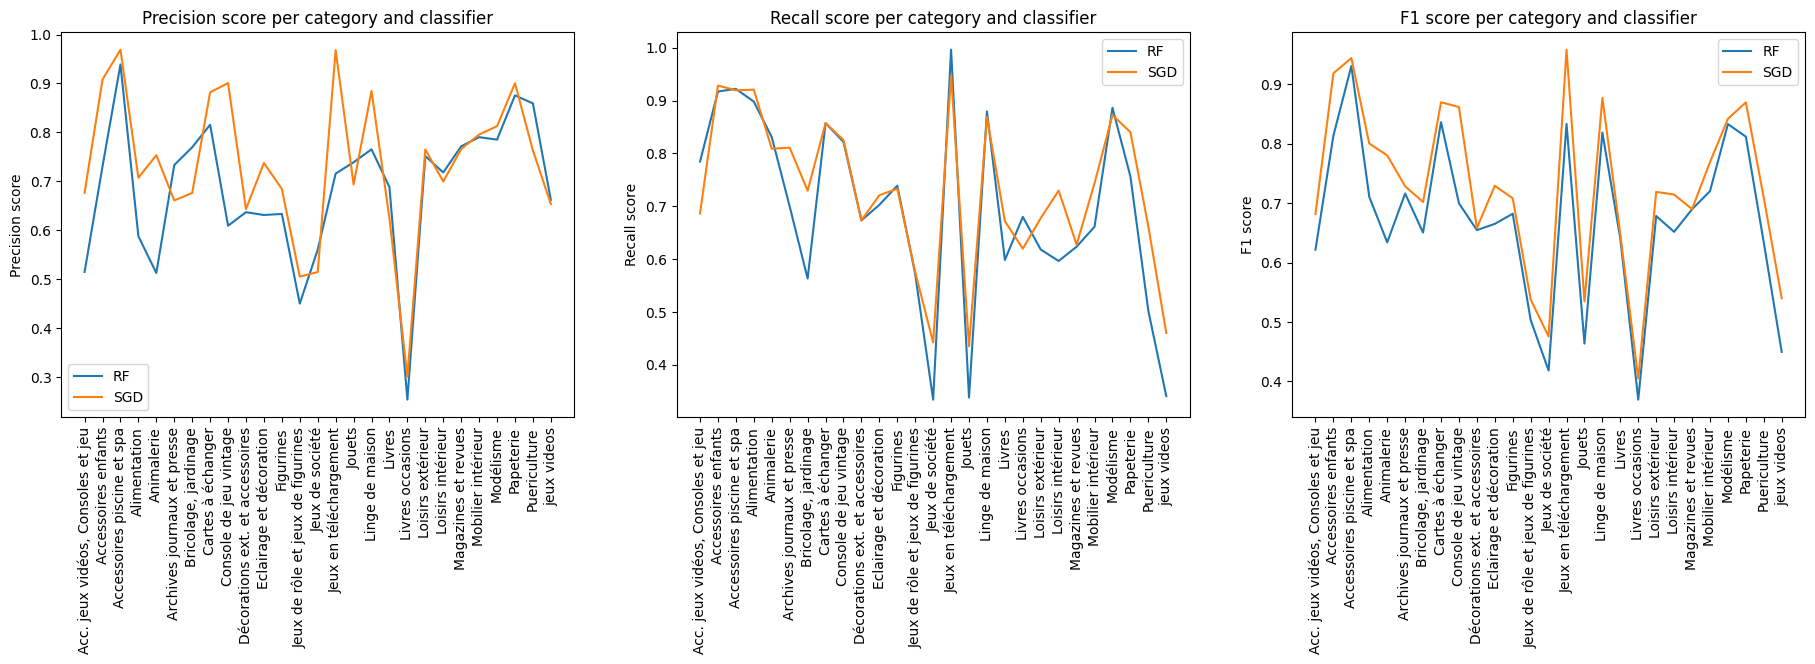

In [ ]:
scores_to_plot = {
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1": f1_scores
}
plot_scores_per_cat_mdl(unique_categories, scores_to_plot)

In [ ]:
# display(precision_scores['RF'].min(), precision_scores['RF'].argmin(), unique_categories.to_list()[precision_scores['RF'].argmin()])
# display(precision_scores['RF'].max(), precision_scores['RF'].argmax(), unique_categories.to_list()[precision_scores['RF'].argmax()])

Le classificateur Stochastic Descent Gradient est le plus satisfaisant : durées d'entraînement et de prédiction plus courtes, meilleure accuracy et suraprentissage bien contenu. Les résultats du classificateur Random Forest sont légèrement moins bons et ce modèle demande un peu plus de temps de calcul, tout en restant rapide.

Si nous regardons les scores de classification produit par produit, nous constatons de fortes disparités. Par exemple, avec le classificateur Random Forest, le score de précision varie de 25% pour les livres d'occasion à 94% pour les accessoires de piscine et spa. Remarquons aussi que les catégories les mieux et les moins bien prédites sont généralement les mêmes entre les deux classificateurs.

Il peut être intéressant de regarder quelles catégories ont été le plus prédites pour chacune des catégories parmi les moins bien prédites.

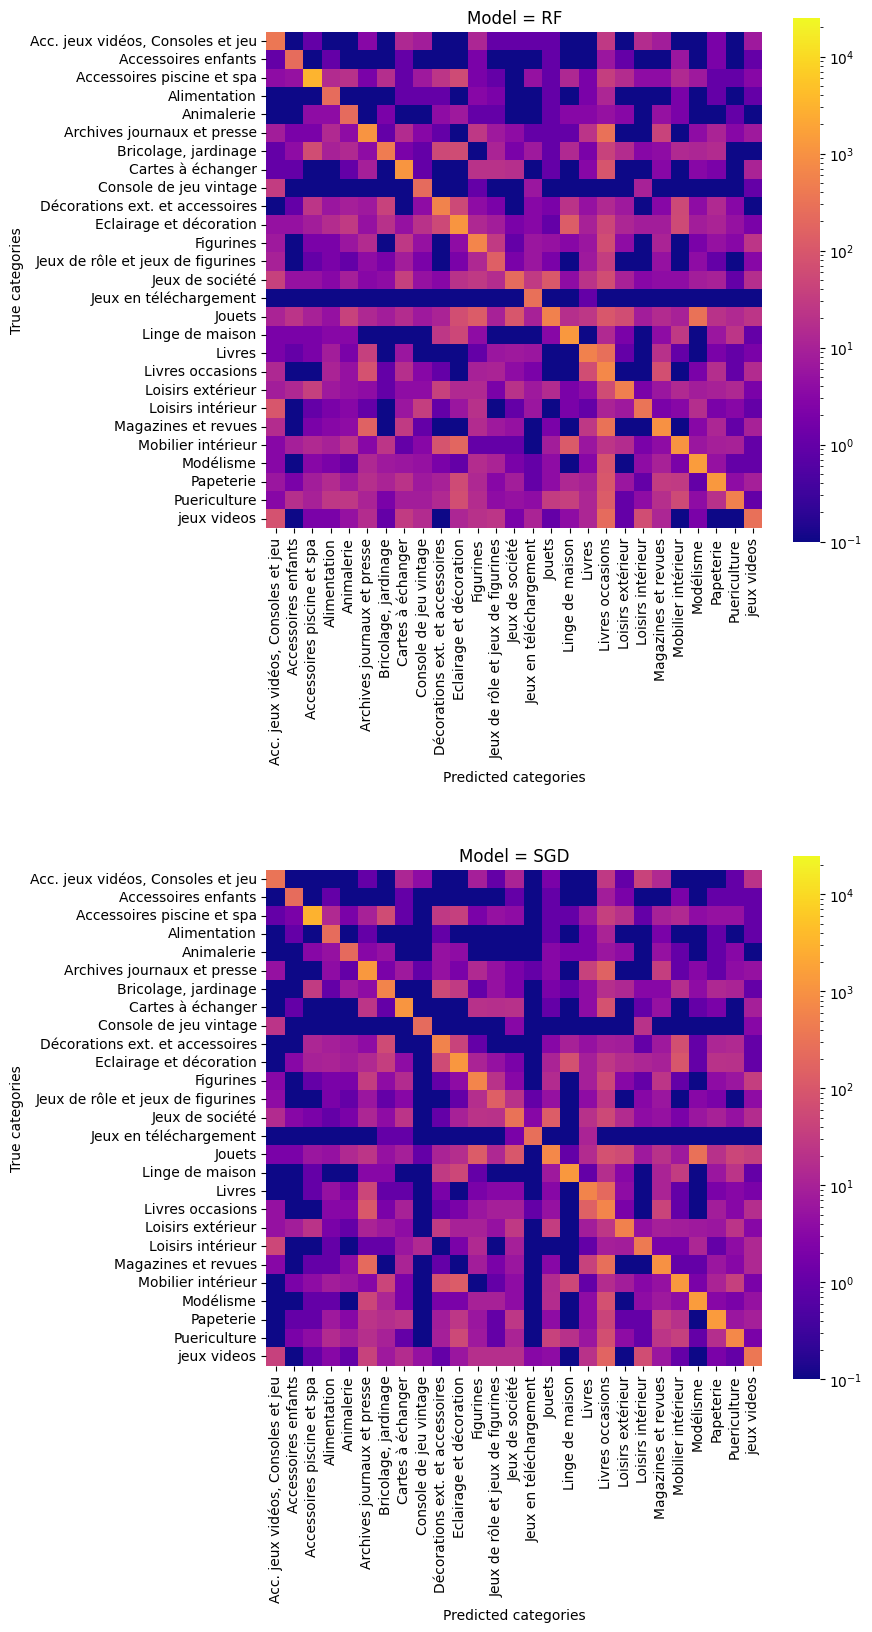

In [ ]:
plot_confusion_matrices(y_test, y_pred_per_clf, ordered_categories=unique_categories)

Parmi les erreurs de classification, certaines paraissent naturelles. Par exemple, parmi les produits classés comme livres d'occasion, nous trouvons un certain nombre de produits étant en réalité des magazines ou revues, des archives de journaux ou encore des livres neufs. D'autres erreurs, plus rares, peuvent paraître surprenantes. Ainsi, toujours parmi les produits prédits comme étant des livres d'occasion, on trouve une proportion non négligeable de jeux vidéo.

In [ ]:
mistake_indexes = X_test[(y_pred_per_clf["RF"] == "Livres occasions") & (y_test == "jeux videos")].head(20).index

df.loc[mistake_indexes, ["designation", "description"]].fillna("")

,designation,description
45319,Les Sims 2 Kit : Glamour,
11216,Merlin's Apprentice - Jeu En Anglais,
63266,Rayman - Les Dictées De Rayman Cm2,
25303,Les Dents De La Mer,
80569,Opération Air Assault 2,
34548,Sherlock Holmes - Crimes And Punishments,
84312,Japon Découvrez Un Pays,
77658,Awakening - Le Réveil De La Princesse,
36687,Les Chevaliers De Baphomet 5 - La Malédiction ...,
54516,Disney Interactive : La Petite Sirène Fais Ton...,


Les quelques exemples de classement erroné présentés ci-dessus (jeux vidéo prédits comme livres d'occasion par le classificateur Random Forest) illustrent la difficulté de l'exercice : seule la désignation du produit est disponible et peut en effet évoquer un livre ou parfois un film.

## *Essai de FastText*

### *Définition de quelques variables*

#### *Répertoire et fichiers (entraînement et test notamment)*

In [ ]:
FASTTEXT_DIR = os.path.join(MODELS_DIR, "fasttext_files")

FASTTEXT_TRAIN_FILE = os.path.join(FASTTEXT_DIR, "train.txt")
FASTTEXT_TEST_FILE = os.path.join(FASTTEXT_DIR, "test.txt")

#### *Conversion des labels d'origine en labels adaptés à FastText*

In [ ]:
fasttext_categories = [
    "__label__" + label.replace(" ", "-").replace(".", "").replace(",", "")
    for label in unique_categories
]
original_to_fasttext_category = dict(zip(unique_categories, fasttext_categories))
fasttext_to_original_categories = dict(zip(fasttext_categories, unique_categories))

### *Création de quelques fonctions : grille d'évaluation d'hyperparamètres, extraction des classes prédites*

In [ ]:
import functools


def fasttext_predicted_labels(model, texts):
  """
  Returns the labels predicted by a FastText model.
  Arguments:
    model: a trained FastText model
    texts: a Pandas Series or a list
  Returns:
    A list of predicted labels in FastText format ("__label__<a label>")
  """
  if isinstance(texts, pd.Series):
    texts = texts.tolist()

  return [lbl[0] for lbl in model.predict(texts)[0]]


# No cross validation here: too complicated with no obvious gain.

def fasttext_grid_search_dataframe(grid_params, train_file_path, train_texts, test_texts, y_train, y_test, fixed_params=None):
  """
  Explores a grid of FastText supervised model hyperparameters and returns a DataFrame with the exploration results.
  Arguments:
    grid_params: Dictionary (grid) of hyperparameters
    train_file_path: path to the train file
    train_texts: Train texts. Must match the content of train_file_path.
    test_texts: Test texts used to assess the models' performance.
    y_train: Train target labels in FastText format ("__label__<a label>"). Must match the content of train_file_path.
    y_test: Test target labels in FastText format. Must be consistent with test_texts.
    fixed_params: If not None, a dictionary of fixed hyperparameters
  Returns: a DataFrame with the following columns:
    params: each value is a dictionary representing one of the hyperparameter grid combinations
    train_score: balanced accuracy scores computed over train data
    test_score: balanced accuracy scores computed over test data
    training_duration: training durations in seconds
    prediction_duration: train + test prediction durations in seconds
    param_<param name>: one column per parameter provided in grid_params
  """
  fasttext_param_counts = {prm: len(vals) for prm, vals in grid_params.items()}
  fasttext_total_param_count = functools.reduce(lambda n, p: n * p, fasttext_param_counts.values(), 1)

  train_params = []
  train_scores = []
  test_scores = []
  train_durations = []
  prediction_durations = []

  print("[{}] Start fasttext training - {} model(s) to evaluate".format(time.strftime("%Y-%m-%d %H:%M:%S"), fasttext_total_param_count))
  for i_param in range(fasttext_total_param_count):
    params = {}
    i = i_param
    for param_name, param_values in grid_params.items():
      param_count = fasttext_param_counts[param_name]
      params[param_name] = param_values[i % param_count]
      i //= param_count
    train_params.append(params)

    all_params = params.copy()
    if fixed_params is not None:
      all_params.update(fixed_params)
    started_at = time.time()
    model = fasttext.train_supervised(train_file_path, **all_params)
    trained_at = time.time()
    train_durations.append(trained_at - started_at)

    train_pred = fasttext_predicted_labels(model, train_texts)
    test_pred = fasttext_predicted_labels(model, test_texts)
    predicted_at = time.time()
    prediction_durations.append(predicted_at - trained_at)

    train_scores.append(balanced_accuracy_score(y_train, train_pred))
    test_scores.append(balanced_accuracy_score(y_test, test_pred))

    print("[%s] Model #%d - Parameters %s - Scores: train = %.3f, test = %.3f, diff = %.3f - Durations: train = %.1f s, prediction = %.1f s" % (
        time.strftime("%Y-%m-%d %H:%M:%S"), i_param + 1, params, train_scores[-1], test_scores[-1], train_scores[-1] - test_scores[-1], train_durations[-1], prediction_durations[-1]
    ))

  fasttext_result_df = pd.DataFrame({
      "params": train_params,
      "train_score": train_scores,
      "test_score": test_scores,
      "training_duration": train_durations,
      "prediction_duration": prediction_durations
  })
  for key in grid_params.keys():
    fasttext_result_df["param_" + key] =  fasttext_result_df["params"].apply(lambda d: d[key])

  return fasttext_result_df

### *Création d'un dataframe adapté*

In [ ]:
# See the doc for more details: fastText trains itself over files,
# where each line contains one or more target classes in the form __label__<my label value> <text used to train>
# A score may be evaluated upon test data written in a file in the same format.

# Use data with stop words removed. It seems to slightly improve results.
# If raw texts are used instead, make sure to replace newlines with spaces (at least one case exists).
df_fasttext = designations_descriptions.to_frame(name="designation_description")
df_fasttext["original_label"] = df["Labels"]
df_fasttext["fasttext_label"] = df_fasttext["original_label"].apply(
    lambda lbl: original_to_fasttext_category[lbl]
)
df_fasttext["fasttext_input"] = df_fasttext.apply(
    lambda row: " ".join([row["fasttext_label"], row["designation_description"].replace("\n", " ")]), axis=1
)

df_fasttext.head(10)


,designation_description,original_label,fasttext_label,fasttext_input
0,olivia : carnet personnalisé / 150 pages / dot...,Livres occasions,__label__Livres-occasions,__label__Livres-occasions olivia : carnet pers...
1,journal arts (le) 133 28/09/2001 - l'art march...,Archives journaux et presse,__label__Archives-journaux-et-presse,__label__Archives-journaux-et-presse journal a...
2,grand stylet ergonomique bleu gamepad nintendo...,Loisirs intérieur,__label__Loisirs-intérieur,__label__Loisirs-intérieur grand stylet ergono...
3,peluche donald - europe - disneyland 2000 (mar...,Jouets,__label__Jouets,__label__Jouets peluche donald - europe - disn...
4,guerre tuques luc a idées grandeur. veut organ...,Livres,__label__Livres,__label__Livres guerre tuques luc a idées gran...
5,afrique contemporaine 212 hiver 2004 - dossier...,Archives journaux et presse,__label__Archives-journaux-et-presse,__label__Archives-journaux-et-presse afrique c...
6,christof e : piste processus éducatifs,Livres occasions,__label__Livres-occasions,__label__Livres-occasions christof e : piste p...
7,conquerant sept cahier couverture polypro 240 ...,Papeterie,__label__Papeterie,__label__Papeterie conquerant sept cahier couv...
8,puzzle scooby-doo poster 2x35 pieces,Jouets,__label__Jouets,__label__Jouets puzzle scooby-doo poster 2x35 ...
9,tente pliante v3s5-pro pvc blanc - 3 x 4m50 - ...,Décorations ext. et accessoires,__label__Décorations-ext-et-accessoires,__label__Décorations-ext-et-accessoires tente ...


### *Séparation en données d'entraînement et de test*

In [ ]:
# Make sure to split the same way as in section "Performances des classificateurs simples sur les différentes catégories de produits"
df_train_ft, df_test_ft, y_train_ft, y_test_ft = project_train_test_split(
    df_fasttext, df_fasttext["fasttext_label"], stratify=df_fasttext["fasttext_label"]
)


### *Ecriture des jeux d'entraînement et de test dans des fichiers*

In [ ]:
for df_to_write, file_path in ((df_train_ft, FASTTEXT_TRAIN_FILE), (df_test_ft, FASTTEXT_TEST_FILE)):
  with open(file_path, "w") as f:
    f.write("\n".join(df_to_write["fasttext_input"]))

### *Entraînement avec différentes valeurs d'hyperparamètres*

#### Calcul

In [ ]:
fasttext_params = {
    "dim": (10, 20, 50, 100),
    "lr": (0.05, 0.1, 0.2, 0.5),
    "wordNgrams": (1, 2, 3),
    "epoch": (2, 4, 6, 8),
    # "loss": ("ns", "hs", "softmax", "ova"),
}

fasttext_result_df = fasttext_grid_search_dataframe(
    fasttext_params,
    FASTTEXT_TRAIN_FILE,
    df_train_ft["designation_description"],
    df_test_ft["designation_description"],
    y_train_ft,
    y_test_ft
)

[2023-07-08 20:26:17] Start fasttext training - 192 model(s) to evaluate
[2023-07-08 20:26:23] Model #1 - Parameters {'dim': 10, 'lr': 0.05, 'wordNgrams': 1, 'epoch': 2} - Scores: train = 0.363, test = 0.362, diff = 0.001 - Durations: train = 3.6 s, prediction = 2.2 s
[2023-07-08 20:26:31] Model #2 - Parameters {'dim': 20, 'lr': 0.05, 'wordNgrams': 1, 'epoch': 2} - Scores: train = 0.365, test = 0.365, diff = -0.000 - Durations: train = 3.8 s, prediction = 3.9 s
[2023-07-08 20:26:40] Model #3 - Parameters {'dim': 50, 'lr': 0.05, 'wordNgrams': 1, 'epoch': 2} - Scores: train = 0.347, test = 0.348, diff = -0.001 - Durations: train = 5.0 s, prediction = 2.9 s
[2023-07-08 20:26:53] Model #4 - Parameters {'dim': 100, 'lr': 0.05, 'wordNgrams': 1, 'epoch': 2} - Scores: train = 0.340, test = 0.340, diff = -0.000 - Durations: train = 8.3 s, prediction = 4.2 s
[2023-07-08 20:26:59] Model #5 - Parameters {'dim': 10, 'lr': 0.1, 'wordNgrams': 1, 'epoch': 2} - Scores: train = 0.540, test = 0.513, diff

In [ ]:
# Save fasttext evaluation results
# fasttext_result_df.to_csv(os.path.join(MODEL_RESULTS_DIR, "fasttext_grid_results_20230704.csv"))

#### Analyse

In [ ]:
# Reload fasttext evaluation results
# fasttext_result_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "fasttext_grid_results_20230704.csv"))

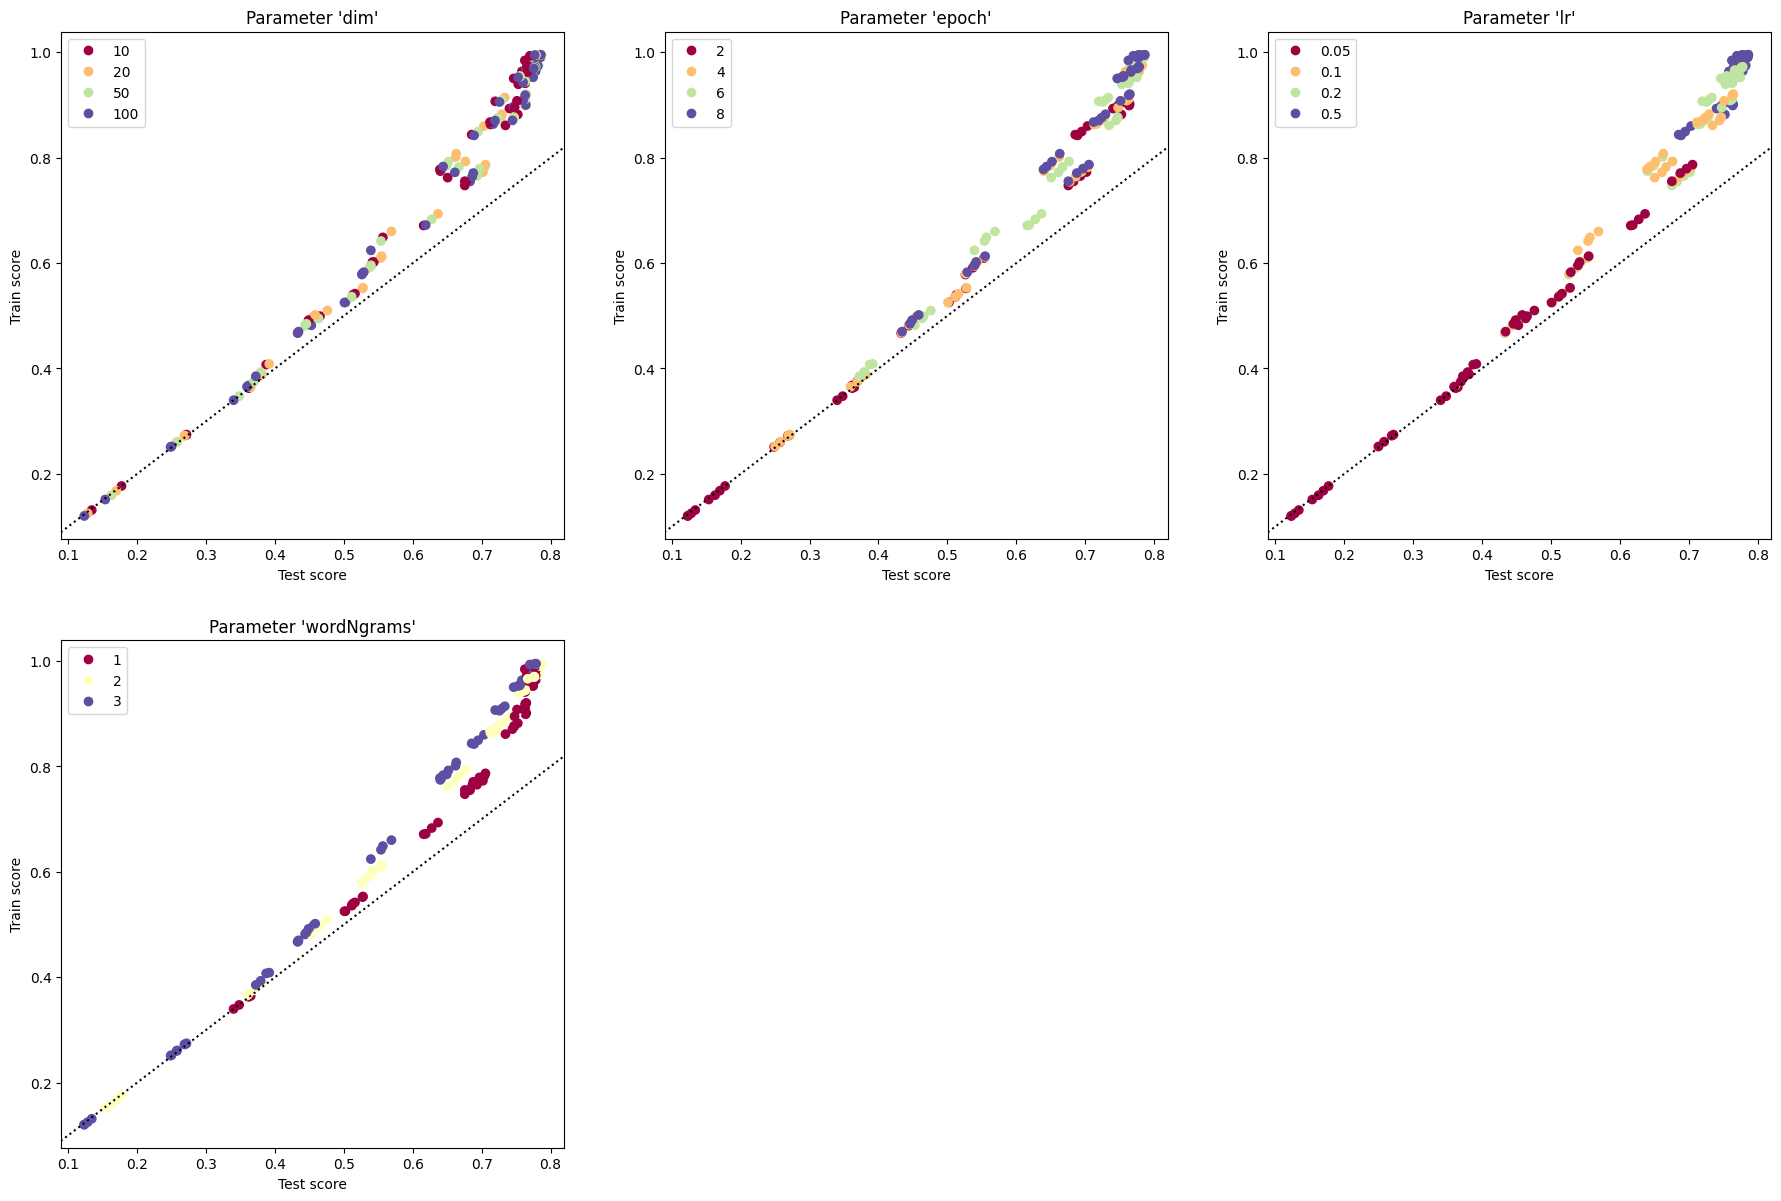

In [ ]:
plot_cvgrid_scores(fasttext_result_df)


Le modèle FastText offre un apprentissage supervisé contrôlé par plusieurs hyperparamètres, parmi lesquels nous avons exploré les suivants :

*   `dim` : nombre de dimensions dans lesquelles projeter les tokens que le modèle extrait
*   `epoch` : nombre d'époques servant à l'entraînement
*   `lr` : "vitesse" d'apprentissage (*learning rate*)
*   `wordNgrams` : nombre maximal de mots/tokens par word-gram

Il ressort plusieurs choses :

*   les scores obtenus sont très variables d'un jeu d'hyperparamètres à l'autre. Difficile d'évaluer à quelles combinaisons d'hyperparamètres les scores les plus faibles tiennent, une exploration détaillée s'impose. Avant cela, il est possible de filtrer certains cas comme exposés ci-dessous
*   les meilleurs scores obtenus sur les données de test correspondent à des modèles ayant obtenu des scores quasi-parfaits sur les données d'entraînement. Un suraprentissage semble inévitable.
*   à ce stade, l'hyperparamètre dont il est le plus facile de rejeter des valeurs est `wordNGrams`. Plus sa valeur est grande, plus les scores seront faibles et/ou plus le suraprentissage sera fort. Nous retiendrons donc une valeur de 1, autrement dit, il faudra travailler avec des mots/tokens individuels et non des séquences de 2 ou 3 mots/tokens.


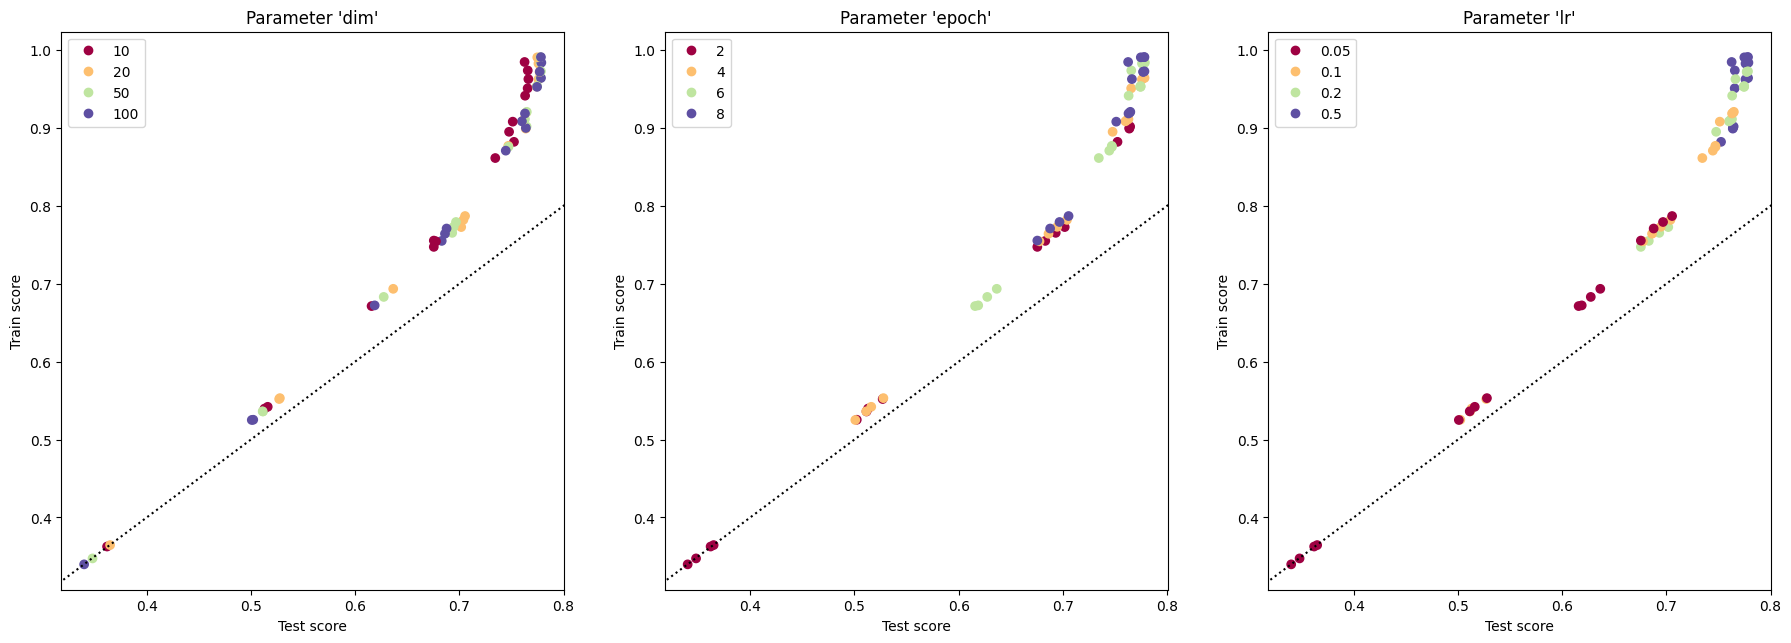

In [ ]:
plot_cvgrid_scores(fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
])

L'analyse reste difficile même après sélection des résultats avec `wordNgrams` égal à 1. Les seuls élément qui ressortent est que l'espace de projection des vecteurs devrait être d'une dimension supérieure ou égale à 20, et que la vitesse d'apprentissage devrait être d'au moins 0.1.

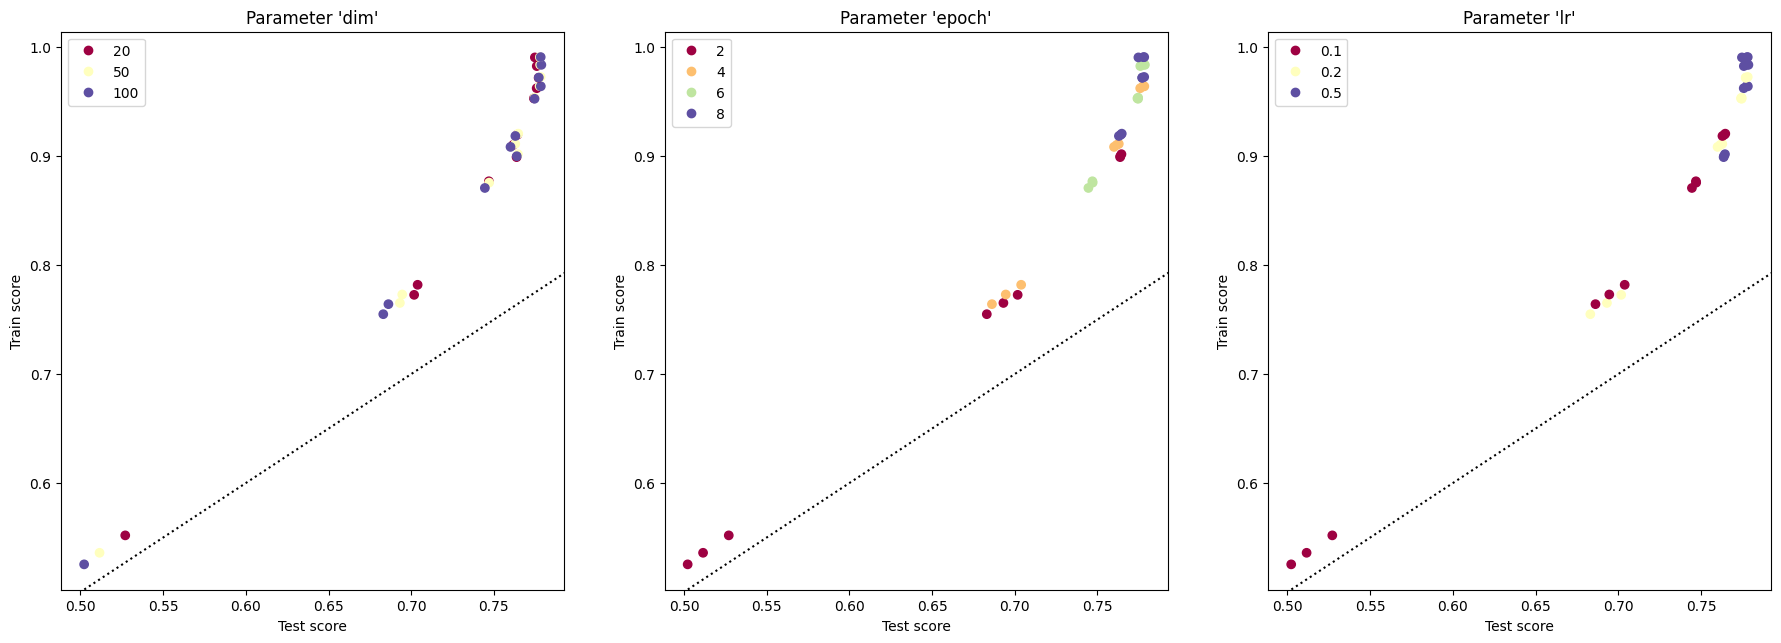

In [ ]:
plot_cvgrid_scores(fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
    & (fasttext_result_df["param_dim"] >= 20)
    & (fasttext_result_df["param_lr"] >= 0.1)
])

In [ ]:
fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
    & (fasttext_result_df["param_dim"] >= 20)
    & (fasttext_result_df["param_lr"] >= 0.1)
    & (fasttext_result_df["test_score"] < 0.65)
].sort_values("test_score", ascending=False)

,params,train_score,test_score,training_duration,prediction_duration,param_dim,param_lr,param_wordNgrams,param_epoch
5,"{'dim': 20, 'lr': 0.1, 'wordNgrams': 1, 'epoch...",0.552005,0.527098,4.886857,2.440813,20,0.1,1,2
6,"{'dim': 50, 'lr': 0.1, 'wordNgrams': 1, 'epoch...",0.536021,0.511559,4.567821,3.925085,50,0.1,1,2
7,"{'dim': 100, 'lr': 0.1, 'wordNgrams': 1, 'epoc...",0.525403,0.502247,7.078913,4.096583,100,0.1,1,2


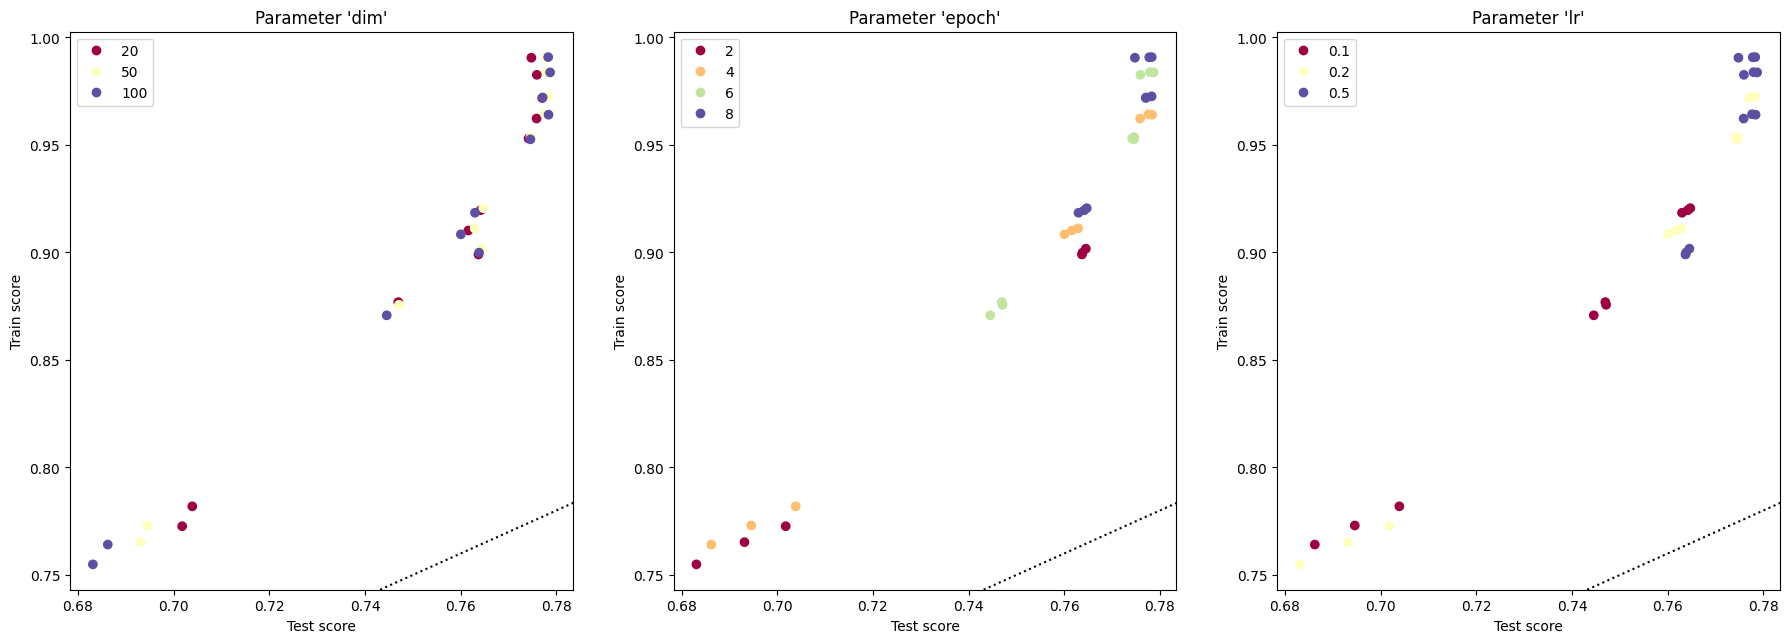

In [ ]:
plot_cvgrid_scores(fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
    & (fasttext_result_df["param_dim"] >= 20)
    & (fasttext_result_df["param_lr"] >= 0.1)
    & (
        (fasttext_result_df["param_lr"] >= 0.2)
        | (fasttext_result_df["param_epoch"] >= 4)
    )
])

Poursuivre la recherche d'hyperparamètres adéquats s'annonce difficile. Il faudrait faire un choix arbitraire parmi les combinaisons données par les contraintes suivantes, en acceptant soit un suraprentissage, soit un sacrifice sur le score de test :

*   `wordNgrams` = 1
*   `dim` >= 20
*   `lr` >= 0.2 et `epoch` >= 2, ou `lr` >= 0.1 et `epoch` >= 4

### *Entraînement avec une liste préchargée de vecteurs et réglage automatique des hyperparamètres*

#### *Calcul*

In [ ]:
model_vec_dim100_autotuned = fasttext.train_supervised(
    FASTTEXT_TRAIN_FILE,
    pretrainedVectors=os.path.join(FASTTEXT_DIR, "cc.fr.100.vec"),
    dim=100,
    autotuneValidationFile=FASTTEXT_TEST_FILE
)

In [ ]:
# Save the autotuned, 100-dim pre-trained vectors model
# model_vec_dim100_autotuned.save_model(os.path.join(SAVED_MODELS_DIR, "model_fasttext_autotune_dim100.bin"))

#### *Analyse*

In [ ]:
# Reload the autotuned, 100-dim pre-trained vectors model
# model_vec_dim100_autotuned = fasttext.load_model(os.path.join(SAVED_MODELS_DIR, "model_fasttext_autotune_dim100.bin"))

# Reload the results obtained with the hyperparameter grid
# fasttext_result_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "fasttext_grid_results_20230704.csv"))

In [ ]:
autotuned_train_pred = fasttext_predicted_labels(model_vec_dim100_autotuned, df_train_ft["designation_description"])
autotuned_train_score = balanced_accuracy_score(y_train_ft, autotuned_train_pred)
autotuned_test_pred = fasttext_predicted_labels(model_vec_dim100_autotuned, df_test_ft["designation_description"])
autotuned_test_score = balanced_accuracy_score(y_test_ft, autotuned_test_pred)

autotuned_train_score, autotuned_test_score

(0.9354657826122874, 0.7787852046361748)

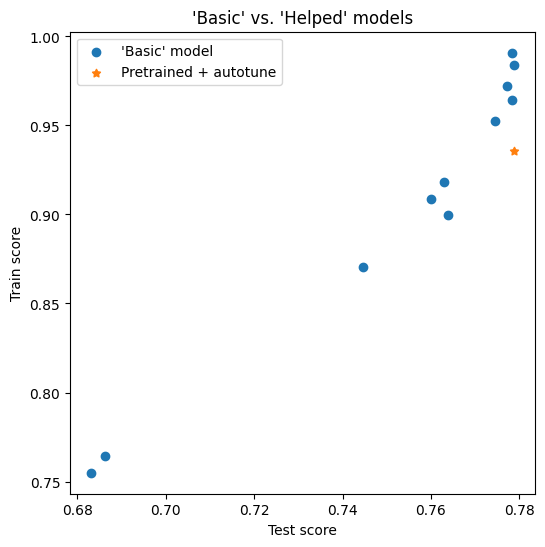

In [ ]:
grid_subresults_df = fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
    & (fasttext_result_df["param_dim"] == 100)
    & (fasttext_result_df["param_lr"] >= 0.1)
    & (
        (fasttext_result_df["param_lr"] >= 0.2)
        | (fasttext_result_df["param_epoch"] >= 4)
    )
]

plt.figure(figsize=(6, 6))
plt.scatter(grid_subresults_df["test_score"], grid_subresults_df["train_score"], label="'Basic' model")
plt.scatter([autotuned_test_score], [autotuned_train_score], marker=(5, 1), label="Pretrained + autotune")
plt.xlabel("Test score")
plt.ylabel("Train score")
plt.title("'Basic' vs. 'Helped' models")
plt.legend();

FastText offre la possibilité d'entraîner des modèles avec des tokens "pré-entraînés", c'est-à-dire déjà projetés dans un espace de grande dimension. Il permet aussi d'ajuster automatiquement les hyperparamètres en précisant un fichier de données de test.

En exploitant ces deux fonctionnalités, nous pouvons constater une légère amélioration par rapport à un modèle "sans aide" : score de test parmi les meilleurs possibles et suraprentissage légèrement moindre.

A noter que nous avons dû adapter le jeu de tokens pré-vectorisés. Ils sont disponibles dans un espace à 300 dimensions sur le site de FastText, mais cela se traduisait par une consommation excessive de mémoire. Nous avons reprojeté les tokens sur un espace de 100 dimensions.

### *Exploration d'hyperparamètres, utilisation de vecteurs pré-établis*

#### *Calcul*

In [ ]:
fasttext_params = {
    "lr": (0.1, 0.2, 0.5),
    "epoch": (2, 4, 6, 8),
    # "loss": ("ns", "hs", "softmax", "ova"),
}

fixed_params = {
    "wordNgrams": 1,
    "dim": 100,
    "pretrainedVectors": os.path.join(FASTTEXT_DIR, "cc.fr.100.vec")
}

fasttext_preloaded_vectors_df = fasttext_grid_search_dataframe(
    fasttext_params,
    FASTTEXT_TRAIN_FILE,
    df_train_ft["designation_description"],
    df_test_ft["designation_description"],
    y_train_ft,
    y_test_ft,
    fixed_params
)


[2023-07-08 21:51:17] Start fasttext training - 12 model(s) to evaluate
[2023-07-08 21:52:55] Model #1 - Parameters {'lr': 0.1, 'epoch': 2} - Scores: train = 0.803, test = 0.729, diff = 0.074 - Durations: train = 94.3 s, prediction = 4.1 s
[2023-07-08 21:54:33] Model #2 - Parameters {'lr': 0.2, 'epoch': 2} - Scores: train = 0.903, test = 0.769, diff = 0.133 - Durations: train = 92.8 s, prediction = 4.2 s
[2023-07-08 21:56:25] Model #3 - Parameters {'lr': 0.5, 'epoch': 2} - Scores: train = 0.952, test = 0.785, diff = 0.168 - Durations: train = 107.2 s, prediction = 4.4 s
[2023-07-08 21:58:13] Model #4 - Parameters {'lr': 0.1, 'epoch': 4} - Scores: train = 0.913, test = 0.772, diff = 0.141 - Durations: train = 103.4 s, prediction = 4.4 s
[2023-07-08 22:00:03] Model #5 - Parameters {'lr': 0.2, 'epoch': 4} - Scores: train = 0.964, test = 0.787, diff = 0.177 - Durations: train = 103.4 s, prediction = 5.0 s
[2023-07-08 22:01:51] Model #6 - Parameters {'lr': 0.5, 'epoch': 4} - Scores: train =

In [ ]:
# Save fasttext evaluation results
# fasttext_preloaded_vectors_df.to_csv(os.path.join(MODEL_RESULTS_DIR, "fasttext_grid_results_pretrained_dim100_20230704.csv"))

#### *Analyse*

In [ ]:
# Reload fasttext evaluation results
# fasttext_preloaded_vectors_df = pd.read_csv(os.path.join(MODEL_RESULTS_DIR, "fasttext_grid_results_pretrained_dim100_20230616.csv"))

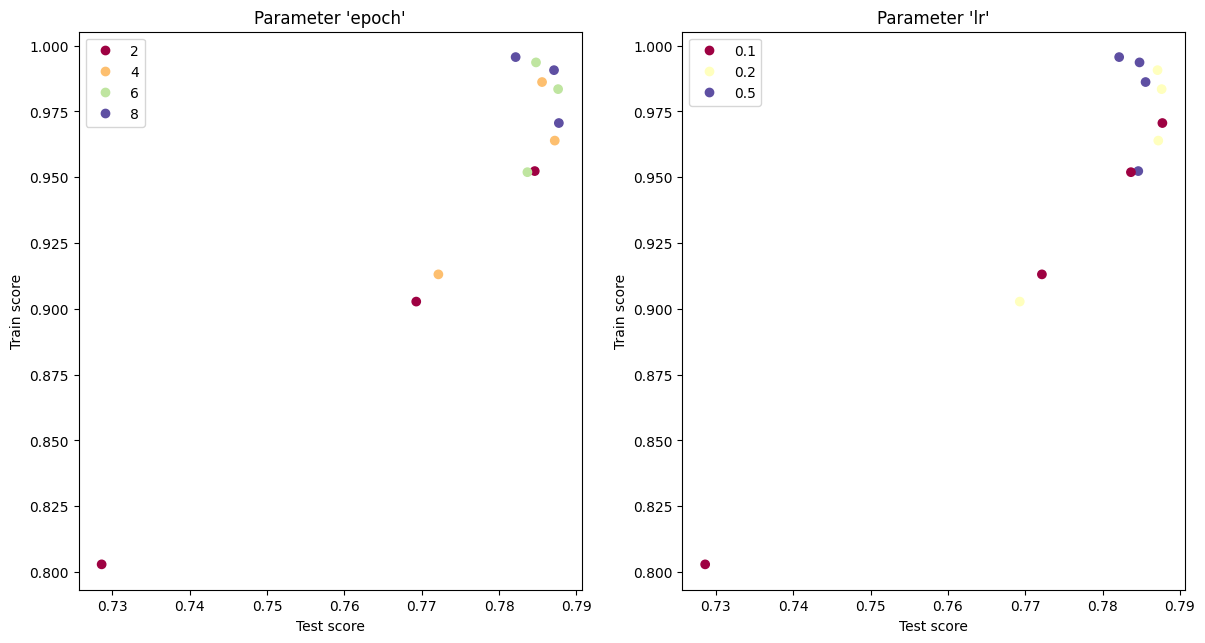

In [ ]:
plot_cvgrid_scores(fasttext_preloaded_vectors_df)

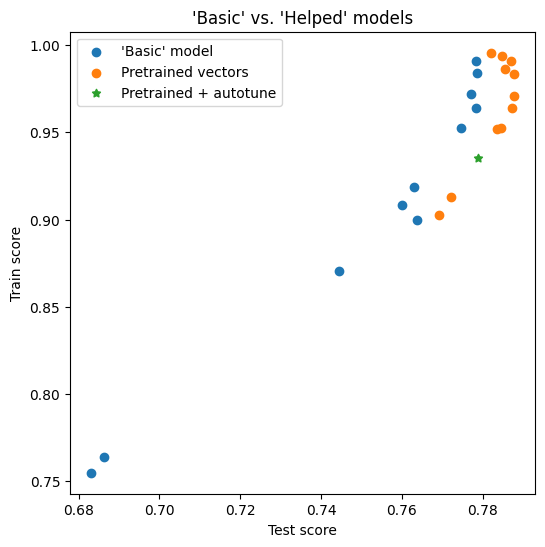

In [ ]:
# Make sure hyperparameter combinations are the same between "basic" models and models with pretrained vectors
basic_grid_subresults_df = fasttext_result_df[
    (fasttext_result_df["param_wordNgrams"] == 1)
    & (fasttext_result_df["param_dim"] == 100)
    & (fasttext_result_df["param_lr"] >= 0.1)
    & (
        (fasttext_result_df["param_lr"] >= 0.2)
        | (fasttext_result_df["param_epoch"] >= 4)
    )
]

pretrained_grid_subresults_df = fasttext_preloaded_vectors_df[
    (fasttext_preloaded_vectors_df["param_lr"] >= 0.2)
    | (fasttext_preloaded_vectors_df["param_epoch"] >= 4)
]

plt.figure(figsize=(6, 6))
plt.scatter(basic_grid_subresults_df["test_score"], basic_grid_subresults_df["train_score"], label="'Basic' model")
plt.scatter(pretrained_grid_subresults_df["test_score"], pretrained_grid_subresults_df["train_score"], label="Pretrained vectors")
plt.scatter([autotuned_test_score], [autotuned_train_score], marker=(5, 1), label="Pretrained + autotune")
plt.xlabel("Test score")
plt.ylabel("Train score")
plt.title("'Basic' vs. 'Helped' models")
plt.legend();

Le graphe ci-dessus montre qu'utiliser des vecteurs pré-entraînés apporte un léger gain dans les scores obtenus sur les données de test. Il n'en reste pas moins que le suraprentissage reste marqué.

In [ ]:
pretrained_grid_subresults_df

,params,train_score,test_score,training_duration,prediction_duration,param_lr,param_epoch
1,"{'lr': 0.2, 'epoch': 2}",0.902739,0.769290,92.761426,4.195619,0.2,2
2,"{'lr': 0.5, 'epoch': 2}",0.952325,0.784609,107.233240,4.412336,0.5,2
3,"{'lr': 0.1, 'epoch': 4}",0.913078,0.772153,103.379311,4.432086,0.1,4
4,"{'lr': 0.2, 'epoch': 4}",0.963904,0.787196,103.409462,5.036269,0.2,4
5,"{'lr': 0.5, 'epoch': 4}",0.986150,0.785554,103.098488,4.415083,0.5,4
6,"{'lr': 0.1, 'epoch': 6}",0.951906,0.783662,113.695082,5.372263,0.1,6
7,"{'lr': 0.2, 'epoch': 6}",0.983462,0.787631,117.044196,4.353117,0.2,6
8,"{'lr': 0.5, 'epoch': 6}",0.993611,0.784773,112.418274,4.820786,0.5,6
9,"{'lr': 0.1, 'epoch': 8}",0.970576,0.787727,119.344985,4.683052,0.1,8
10,"{'lr': 0.2, 'epoch': 8}",0.990668,0.787101,120.675606,5.446855,0.2,8


### *Comparaison entre FastText et les modèles "classiques"*

#### *Fonction : traduction des labels FastText en labels originaux*

In [ ]:
# Translate FastText labels back to "original" labels
def original_label_series(fasttext_labels):
  return pd.Series(fasttext_labels).apply(lambda lbl: fasttext_to_original_categories.get(lbl, lbl))


#### *Entraînement d'un modèle avec des hyperparamètres adéquats*

In [ ]:
# Run a model with pretrained vectors + hyperparameters that offer a reasonable compromise
# between test score and overfitting
selected_fasttext_model = fasttext.train_supervised(
    FASTTEXT_TRAIN_FILE,
    pretrainedVectors=os.path.join(FASTTEXT_DIR, "cc.fr.100.vec"),
    dim=100,
    lr=0.2,
    epoch=2,
    wordNgrams=1,
)

selected_fasttext_train_pred = fasttext_predicted_labels(selected_fasttext_model, df_train_ft["designation_description"])
selected_fasttext_train_score = balanced_accuracy_score(y_train_ft, selected_fasttext_train_pred)
selected_fasttext_test_pred = fasttext_predicted_labels(selected_fasttext_model, df_test_ft["designation_description"])
selected_fasttext_test_score = balanced_accuracy_score(y_test_ft, selected_fasttext_test_pred)

selected_fasttext_train_score, selected_fasttext_test_score

(0.9027387863783893, 0.7692900928189931)

In [ ]:
# Save the 100-dim pre-trained vectors, manually selected hyperparameters model
# selected_fasttext_model.save_model(os.path.join(SAVED_MODELS_DIR, "model_fasttext_manual_hyperparams_vec_dim100.bin"))

#### *Analyse*

In [ ]:
# Reload the 100-dim pre-trained vectors, manually selected hyperparameters model
#selected_fasttext_model = fasttext.load_model(os.path.join(SAVED_MODELS_DIR, "model_fasttext_manual_hyperparams_vec_dim100.bin"))

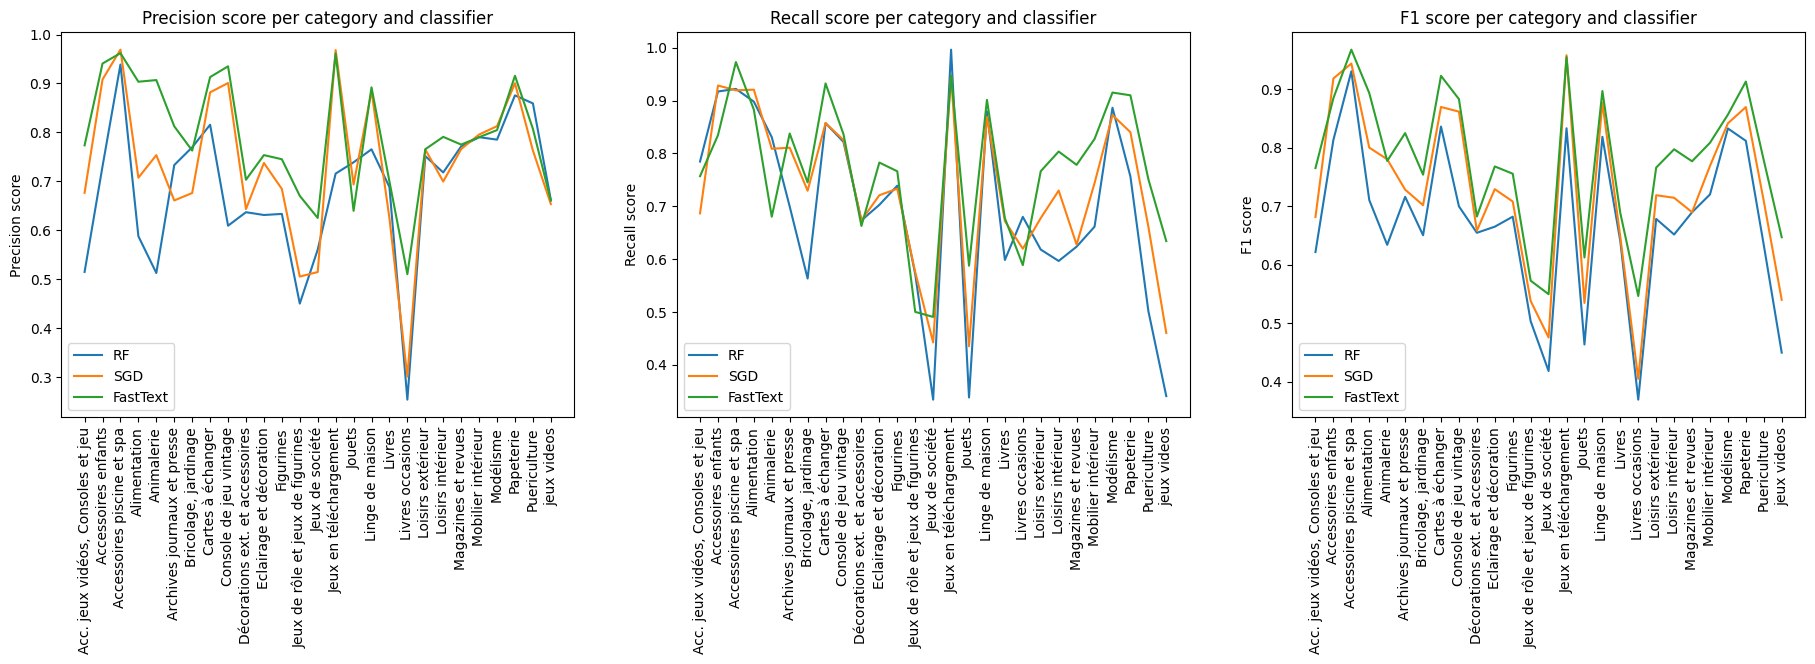

In [ ]:
# WARNING: variables precision_scores, recall_score and f1_score must have been computed
# If not, within section "Performances des classificateurs "classiques" sur les différentes catégories de produits",
# please run cells of sub-section "Calcul des scores sur les données de test, y compris par catégorie de produits"

y_pred_selected_fasttext = original_label_series(fasttext_predicted_labels(selected_fasttext_model, X_test))

fasttext_name = "FastText"
precision_scores_with_ft = precision_scores.copy()
precision_scores_with_ft[fasttext_name] = precision_score(y_test, y_pred_selected_fasttext, average=None, labels=unique_categories)
recall_scores_with_ft = recall_scores.copy()
recall_scores_with_ft[fasttext_name] = recall_score(y_test, y_pred_selected_fasttext, average=None, labels=unique_categories)
f1_scores_with_ft = f1_scores.copy()
f1_scores_with_ft[fasttext_name] = f1_score(y_test, y_pred_selected_fasttext, average=None, labels=unique_categories)

scores_to_plot = {
    "Precision": precision_scores_with_ft,
    "Recall": recall_scores_with_ft,
    "F1": f1_scores_with_ft
}

plot_scores_per_cat_mdl(unique_categories, scores_to_plot)

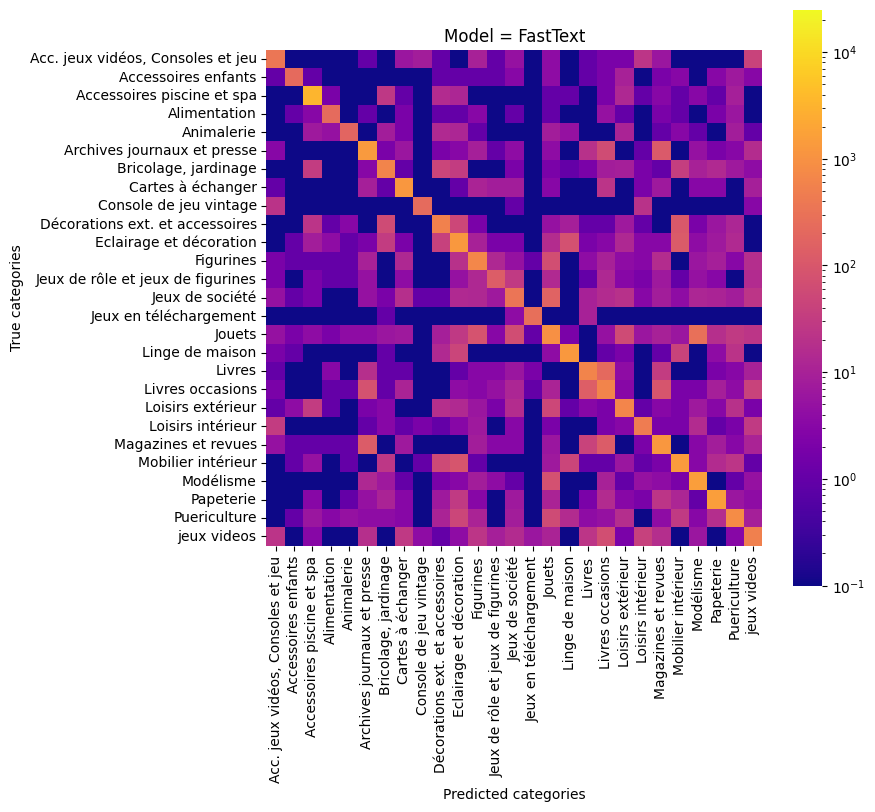

In [ ]:
plot_confusion_matrices(y_test, {fasttext_name: y_pred_selected_fasttext}, ordered_categories=unique_categories)

In [ ]:
# Evaluation des F1-score par classes
print(classification_report(y_test,y_pred_selected_fasttext))

                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.82      0.72      0.77       469
              Accessoires enfants       0.96      0.67      0.79       266
       Accessoires piscine et spa       0.97      0.96      0.97      3369
                     Alimentation       0.95      0.77      0.85       265
                       Animalerie       0.97      0.42      0.59       272
      Archives journaux et presse       0.82      0.83      0.82      1571
             Bricolage, jardinage       0.59      0.82      0.69       824
                Cartes à échanger       0.94      0.91      0.92      1305
           Console de jeu vintage       0.95      0.82      0.88       275
  Décorations ext. et accessoires       0.76      0.56      0.65       854
          Eclairage et décoration       0.68      0.83      0.75      1648
                        Figurines       0.77      0.71      0.74       881
Jeux de rôle et jeux de 

In [ ]:
# analyse des mauvaises prédictions
import itertools # Pour créer des iterateurs
print("Résultats des classes les plus mal prédites avec FastText : ")
unique_categories = df['Labels'].drop_duplicates()
cm_ft = confusion_matrix(y_test,y_pred_selected_fasttext, labels=unique_categories)
confusion_norm_ft = cm_ft.astype('float') / cm_ft.sum(axis=1)[:, np.newaxis]
for i, j in itertools.product(range(cm_ft.shape[0]), range(cm.shape[1])):
    if(confusion_norm_ft[i,j]*100>14 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(unique_categories.iloc[i], unique_categories.iloc[j]))

Résultats des classes les plus mal prédites avec FastText : 
La classe Livres occasions a souvent été prise pour la classe Livres
La classe Livres a souvent été prise pour la classe Livres occasions
La classe Décorations ext. et accessoires a souvent été prise pour la classe Bricolage, jardinage
La classe Jeux de société a souvent été prise pour la classe Jouets
La classe Jeux de rôle et jeux de figurines a souvent été prise pour la classe Jeux de société
La classe Jeux en téléchargement a souvent été prise pour la classe Livres


### *Bilan*

Ce que nous pouvons retenir des modèles FastText :

*   leurs performances sur des données de test peuvent être supérieures à celles des modèles classiques
*   attention toutefois au suraprentissage, souvent très fort avec des scores d'"accuracy pondérée" de presque 100% sur les données d'entraînement là ou les scores ne dépassent pas 80% sur les données de test
*   l'utilisation de vecteurs pré-entraînés améliore légèrement les résultats
*   FastText propose une optimisation automatique des hyperparamètres de son modèle supervisé, mais la recherche manuelle de ces hyperparamètres peut s'avérer utile, notamment pour limiter le suraprentissage
*   le modèle FastText que nous avons sélectionné donne une accuracy comparable aux modèles classiques (TF-IDF + random forest et stochastic gradient descent) avec toutefois un peu moins de disparités entre classes à prédire

Il est probable qu'une combinaison de différents modèles de text mining apporte des résultats encore meilleurs et plus robustes.

## *Essai Word2Vec*

**Word2vec** est un groupe de modèles utilisé pour le plongement lexical (word embedding). Ces modèles ont été développés par une équipe de recherche chez Google

### *Application du modèle Word2Vec*

**Word2Vec :** Cet algorithme de word embedding est parmi les plus connus. Il a été développé par une équipe de recherche de Google. Il repose sur des réseaux de neurones à deux couches et cherche à apprendre les représentations vectorielles des mots composant un texte, de telle sorte que les mots qui partagent des contextes similaires soient représentés par des vecteurs numériques proches.

**Le word embedding** repose sur la théorie linguistique fondée par Zelling Harris et connue sous le nom de Distributional Semantics. Cette théorie considère qu’un mot est caractérisé par son contexte, c’est à dire par les mots qui l’entourent. Ainsi, des mots qui partagent des contextes similaires partagent également des significations similaires. Les algorithmes de word embedding sont le plus souvent employés pour décrire des mots à travers des vecteurs numériques, mais ils peuvent également être utilisés pour construire des représentations vectorielles de phrases entières, de données biologiques comme les séquence d’ADN, ou encore des réseaux représentés comme des graphes.

In [ ]:
# Entraînez un modèle Word2Vec sur les données d'entraînement prétraitées à l'aide du package Gensim
from gensim.models import Word2Vec

# Définition des hyperparamètres
dimension = 300
window = 5
min_count = 1
epochs = 6

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size = dimension, window=window, min_count=min_count, epochs=epochs)

# Exemples de tests
word_similarities = w2v_model.wv.most_similar("console")
print("Mots similaires à 'livre':", word_similarities)


Mots similaires à 'livre': [('neogeo.', 0.8035101294517517), ('fc', 0.7938042879104614), ('manette', 0.7849915623664856), ('ns', 0.7660680413246155), ('nintendo', 0.7629213929176331), ('nes', 0.7598105669021606), ('n-switch', 0.756683349609375), ('joystick', 0.7559950947761536), ('consoles', 0.7557776570320129), ('tlphone', 0.7538975477218628)]


In [ ]:
# Convertissez les données textuelles prétraitées en une représentation vectorielle à l'aide du modèle Word2Vec.
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(dimension)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_v = np.array([vectorize(sentence) for sentence in X_train])
X_test_v = np.array([vectorize(sentence) for sentence in X_test])
X_train_v.shape

(56893, 300)

### *Exploration des précédents classificateurs (RF, SGD) sur les différentes catégories de produits*

In [ ]:
# Imports needed in most of the cells below
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report


In [ ]:
# Try random forest with different parameters

rf_param_grid = {
    "max_features": (50, 70),
    "min_samples_leaf": (5, 7),
    "min_samples_split" : (7, 10)
}

rf_clf = RandomForestClassifier(
    n_estimators=80, # a positionner entre 100 et 1000
    criterion="gini",
    random_state=22,
    class_weight="balanced"
)

grid_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    verbose=3,
    cv=3,
    refit=False,
    return_train_score=True
)

grid_rf.fit(X_train_v, y_train)

grid_rf_result_df = pd.DataFrame(grid_rf.cv_results_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_features=50, min_samples_leaf=5, min_samples_split=7;, score=(train=0.964, test=0.663) total time= 3.9min
[CV 2/3] END max_features=50, min_samples_leaf=5, min_samples_split=7;, score=(train=0.964, test=0.653) total time= 3.9min
[CV 3/3] END max_features=50, min_samples_leaf=5, min_samples_split=7;, score=(train=0.963, test=0.663) total time= 3.8min
[CV 1/3] END max_features=50, min_samples_leaf=5, min_samples_split=10;, score=(train=0.964, test=0.663) total time= 3.8min
[CV 2/3] END max_features=50, min_samples_leaf=5, min_samples_split=10;, score=(train=0.964, test=0.653) total time= 3.8min
[CV 3/3] END max_features=50, min_samples_leaf=5, min_samples_split=10;, score=(train=0.963, test=0.663) total time= 3.9min
[CV 1/3] END max_features=50, min_samples_leaf=7, min_samples_split=7;, score=(train=0.934, test=0.659) total time= 3.8min
[CV 2/3] END max_features=50, min_samples_leaf=7, min_samples_split=7;, scor

In [ ]:
# The best score
print(grid_rf.best_params_)
print(grid_rf.best_score_)

# Save results of grid search upon random forest into a CSV file
grid_rf_result_df.to_csv(os.path.join(DRIVE_PATH, "Luc/text_mining_W2v_grid_random_forest_results_20230529.csv"))

{'max_features': 50, 'min_samples_leaf': 5, 'min_samples_split': 7}
0.6594103619230625


In [ ]:
# Load previously saved results of grid search upon random forest
# grid_rf_result_df = pd.read_csv(os.path.join(DRIVE_PATH, "Luc/text_mining_W2v_grid_random_forest_results_20230521.csv"))

In [ ]:
# Try stochastic gradient descent with different parameters
sgd_param_grid = {
    "alpha": (0.0001, 0.0002, 0.0005, 0.001),
    "l1_ratio": (0., 0.2, 0.4, 0.8, 1.),
    "loss": ("hinge", "log_loss", "perceptron"),
}

sgd_clf = SGDClassifier(
    penalty="elasticnet",
    random_state=22,
    class_weight="balanced"
)

grid_sgd = GridSearchCV(
    estimator=sgd_clf,
    param_grid=sgd_param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    verbose=3,
    cv=3,
    refit=False,
    return_train_score=True
)

grid_sgd.fit(X_train_v, y_train)

grid_sgd_result_df = pd.DataFrame(grid_sgd.cv_results_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END alpha=0.0001, l1_ratio=0.0, loss=hinge;, score=(train=0.629, test=0.616) total time=  37.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.0, loss=hinge;, score=(train=0.631, test=0.617) total time=  36.3s
[CV 3/3] END alpha=0.0001, l1_ratio=0.0, loss=hinge;, score=(train=0.646, test=0.623) total time=  40.5s
[CV 1/3] END alpha=0.0001, l1_ratio=0.0, loss=log_loss;, score=(train=0.649, test=0.635) total time=  31.5s
[CV 2/3] END alpha=0.0001, l1_ratio=0.0, loss=log_loss;, score=(train=0.654, test=0.636) total time=  32.3s
[CV 3/3] END alpha=0.0001, l1_ratio=0.0, loss=log_loss;, score=(train=0.661, test=0.640) total time=  30.8s
[CV 1/3] END alpha=0.0001, l1_ratio=0.0, loss=perceptron;, score=(train=0.520, test=0.507) total time=  33.5s
[CV 2/3] END alpha=0.0001, l1_ratio=0.0, loss=perceptron;, score=(train=0.515, test=0.502) total time=  35.9s
[CV 3/3] END alpha=0.0001, l1_ratio=0.0, loss=perceptron;, score=(train=0.575, 

In [ ]:
# The Best score
print(grid_sgd.best_params_)
print(grid_sgd.best_score_)

# Save results of grid search upon SGD into a CSV file
grid_sgd_result_df.to_csv(os.path.join(DRIVE_PATH, "Luc/text_mining_W2v_sgd_results_20230529.csv"))

{'alpha': 0.0001, 'l1_ratio': 0.8, 'loss': 'log_loss'}
0.6388893010163895


In [ ]:
# Reload results of grid search upon SGD
# grid_sgd_result_df = pd.read_csv(os.path.join(DRIVE_PATH, "Luc/text_mining_W2v_sgd_results_20230521.csv"))

### *Performance des différents classificateurs avec les meilleurs résultats*

In [ ]:
# Try classifiers with their chosen hyperparameters and check which product categories are better or less well predicted
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report
from sklearn.preprocessing import LabelEncoder

rf_clf = RandomForestClassifier(
    class_weight="balanced",
    random_state=37,
    n_estimators=80,
    criterion="gini",
    max_depth=200,
    max_features=70,
    min_samples_split=7,
    min_samples_leaf=7
)
sgd_clf = SGDClassifier(
    class_weight="balanced",
    random_state=53,
    alpha=0.0001,
    l1_ratio=0.2,
    loss="log_loss"
)

unique_categories = y_test.drop_duplicates()
precision_scores = {
    "category": unique_categories
}
recall_scores = {
    "category": unique_categories
}
f1_scores = {
    "category": unique_categories
}
y_pred_per_clf = {}
names_and_clf = (("RF", rf_clf), ("SGD", sgd_clf))
for name, clf in names_and_clf:
  print("\n\n")

  started_at = time.time()
  clf.fit(X_train_v, y_train)
  fit_at = time.time()
  fitting_duration = fit_at - started_at

  y_pred_train = clf.predict(X_train_v)
  y_pred_test = clf.predict(X_test_v)
  predicted_at = time.time()
  prediction_duration = predicted_at - fit_at

  y_pred_per_clf[name] = y_pred_test

  train_score = balanced_accuracy_score(y_train, y_pred_train)
  test_score = balanced_accuracy_score(y_test, y_pred_test)
  report = classification_report(y_test, y_pred_test)
  print("[%s] Results for %s classifier: fitting duration = %.1f s, prediction duration = %.1f s, train score = %.3f, test score = %.3f, classification report on test data:\n%s" % (
      time.strftime("%Y-%m-%d %H:%M:%S"), name, fitting_duration, prediction_duration, train_score, test_score, report
  ))

  precision_scores[name] = precision_score(y_test, y_pred_test, average=None, labels=unique_categories)
  recall_scores[name] = recall_score(y_test, y_pred_test, average=None, labels=unique_categories)
  f1_scores[name] = f1_score(y_test, y_pred_test, average=None, labels=unique_categories)

def create_score_df(scores_per_clf_cat):
  df = pd.DataFrame(scores_per_clf_cat).set_index("category")
  df["avg"] = df[[name for name, _ in names_and_clf]].mean(axis=1)
  return df

precision_score_df = create_score_df(precision_scores)
recall_score_df = create_score_df(recall_scores)
f1_score_df = create_score_df(f1_scores)





[2023-07-09 17:52:30] Results for RF classifier: fitting duration = 528.4 s, prediction duration = 2.5 s, train score = 0.937, test score = 0.665, classification report on test data:
                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.60      0.72      0.65       469
              Accessoires enfants       0.84      0.67      0.75       266
       Accessoires piscine et spa       0.93      0.94      0.93      3369
                     Alimentation       0.65      0.78      0.71       265
                       Animalerie       0.63      0.59      0.61       272
      Archives journaux et presse       0.64      0.64      0.64      1571
             Bricolage, jardinage       0.58      0.60      0.59       824
                Cartes à échanger       0.75      0.84      0.79      1305
           Console de jeu vintage       0.89      0.80      0.85       275
  Décorations ext. et accessoires       0.61      0.60      0.6

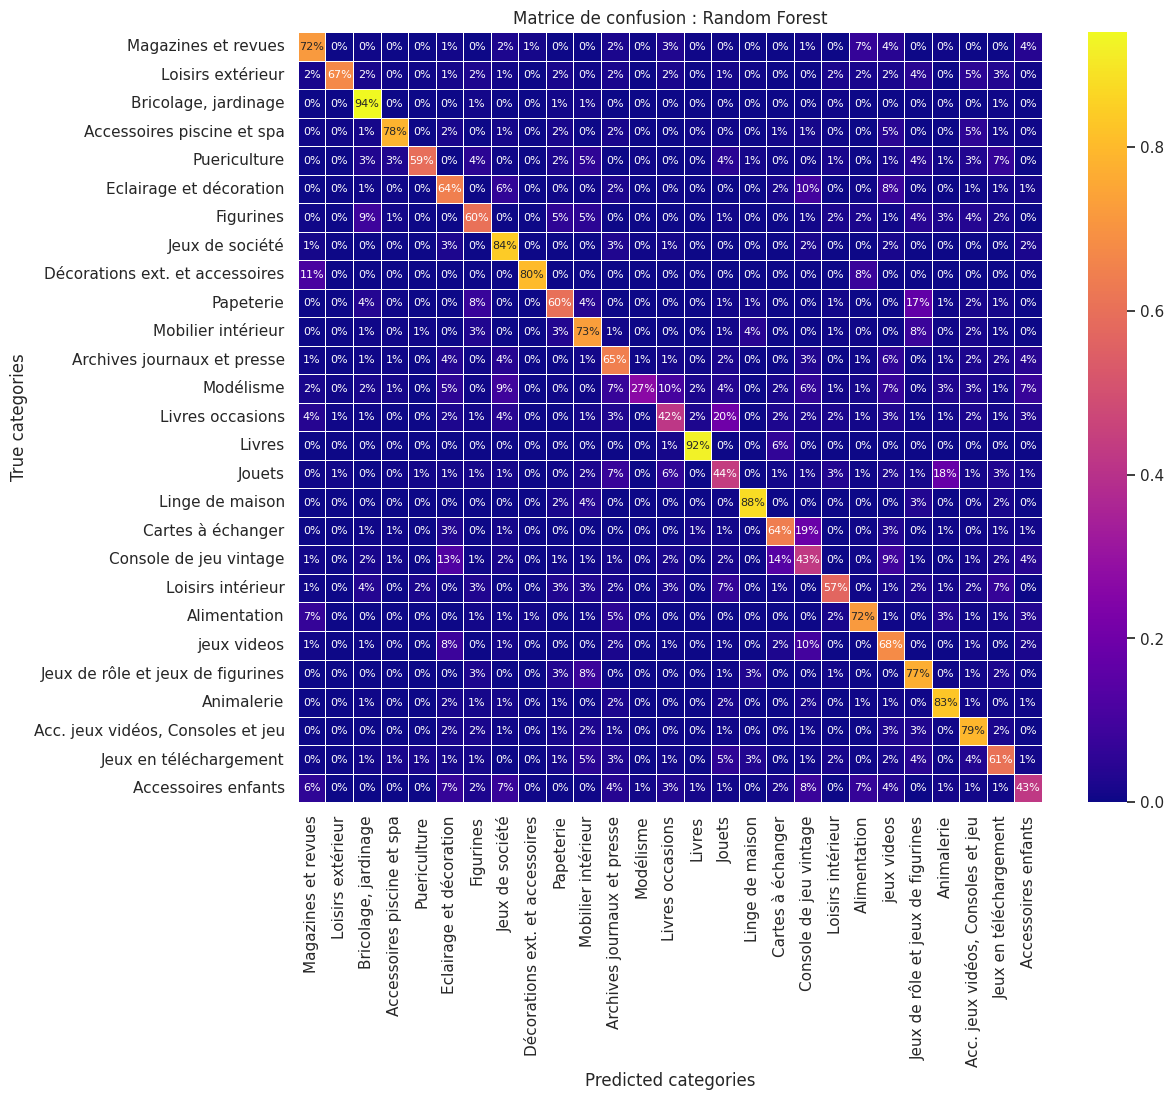

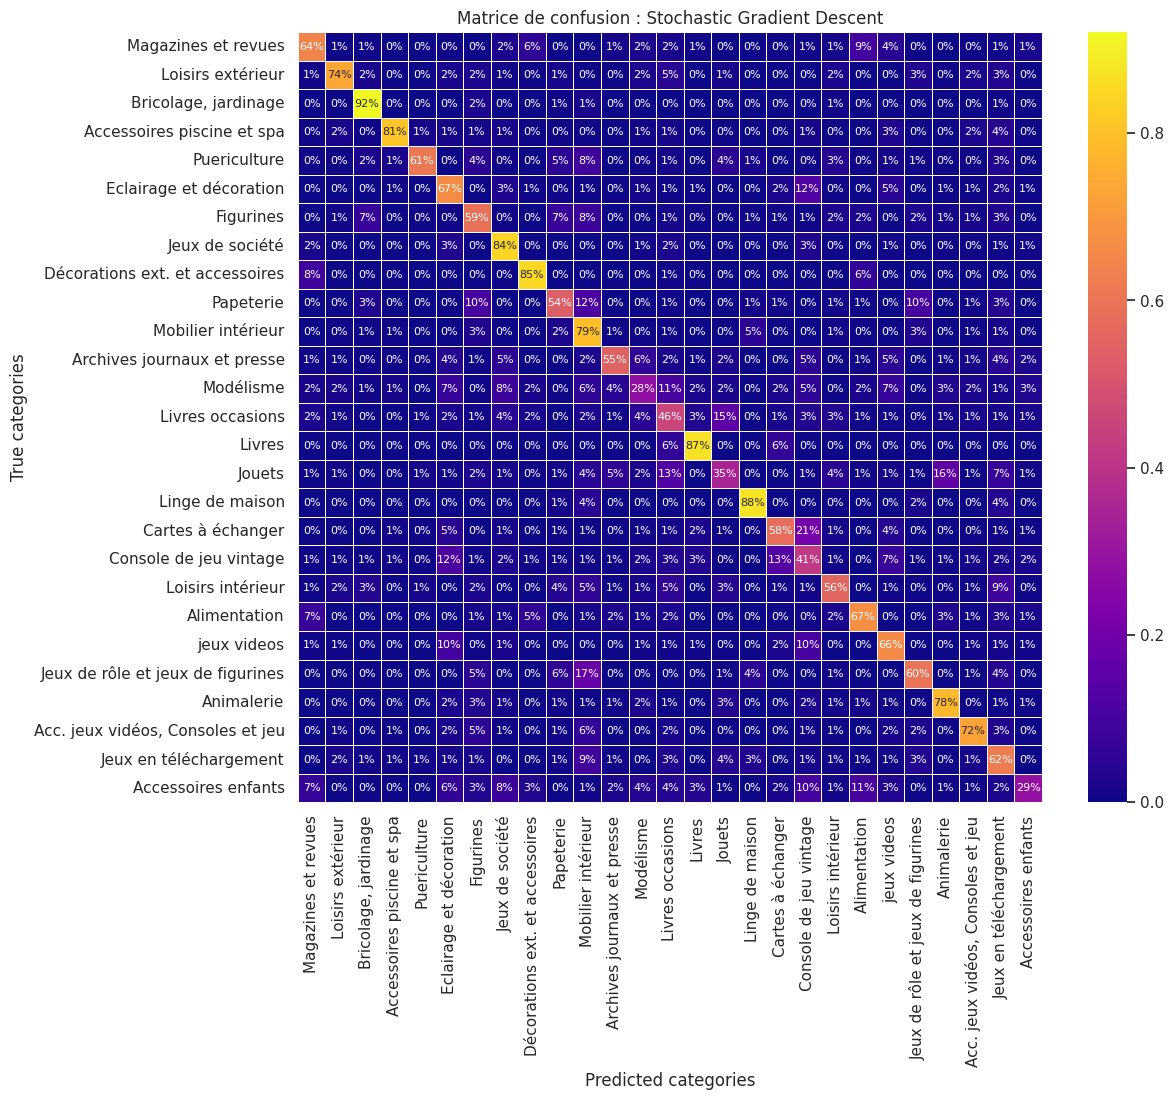

In [ ]:
# affichage de la matrice de confusion pour les deux modèles
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # pour modifier le thème
from sklearn.metrics import confusion_matrix

y_pred_rf=rf_clf.predict(X_test_v)
y_pred_sgd=sgd_clf.predict(X_test_v)

# Calcul
cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_sgd = confusion_matrix(y_test,y_pred_sgd)

confusion_norm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
plt.rcParams.update({'font.size': 8})

# Afficher la heatmap de la matrice de confusion
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_norm_rf, annot=True, cmap=plt.cm.plasma, fmt=".0%", cbar_kws={"shrink": 1.0}, linewidth=.5, xticklabels=unique_categories, yticklabels=unique_categories)

plt.xlabel("Predicted categories")
plt.ylabel("True categories")
plt.title("Matrice de confusion : Random Forest")

confusion_norm_sgd = cm_sgd.astype('float') / cm_sgd.sum(axis=1)[:, np.newaxis]
plt.rcParams.update({'font.size': 8})

# Afficher la heatmap de la matrice de confusion
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_norm_sgd, annot=True, cmap=plt.cm.plasma, fmt=".0%", cbar_kws={"shrink": 1.0}, linewidth=.5, xticklabels=unique_categories, yticklabels=unique_categories)

plt.xlabel("Predicted categories")
plt.ylabel("True categories")
plt.title("Matrice de confusion : Stochastic Gradient Descent")
plt.show();


In [ ]:
# analyse des mauvaises prédictions
import itertools # Pour créer des iterateurs
print("Résultats des classes les plus mal prédites avec Random Forest : ")
for i, j in itertools.product(range(cm_rf.shape[0]), range(cm_rf.shape[1])):
    if(confusion_norm_rf[i,j]*100>14 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(unique_categories.iloc[i], unique_categories.iloc[j]))

Résultats des classes les plus mal prédites avec Random Forest : 
La classe Linge de maison a souvent été prise pour la classe Animalerie
La classe Jeux de rôle et jeux de figurines a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu
La classe Acc. jeux vidéos, Consoles et jeu a souvent été prise pour la classe Jeux en téléchargement
La classe Eclairage et décoration a souvent été prise pour la classe jeux videos


In [ ]:
print("Résultats des classes les plus mal prédites avec SGD : ")
for i, j in itertools.product(range(cm_sgd.shape[0]), range(cm_sgd.shape[1])):
    if(confusion_norm_sgd[i,j]*100>14 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(unique_categories.iloc[i], unique_categories.iloc[j]))

Résultats des classes les plus mal prédites avec SGD : 
La classe Jeux de rôle et jeux de figurines a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu
La classe Acc. jeux vidéos, Consoles et jeu a souvent été prise pour la classe Jeux en téléchargement
La classe Eclairage et décoration a souvent été prise pour la classe jeux videos
La classe Animalerie a souvent été prise pour la classe Magazines et revues


### *Essai Word2vec avec un réseau dense*

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
encoder.classes_

array(['Acc. jeux vidéos, Consoles et jeu', 'Accessoires enfants',
       'Accessoires piscine et spa', 'Alimentation', 'Animalerie',
       'Archives journaux et presse', 'Bricolage, jardinage',
       'Cartes à échanger', 'Console de jeu vintage',
       'Décorations ext. et accessoires', 'Eclairage et décoration',
       'Figurines', 'Jeux de rôle et jeux de figurines',
       'Jeux de société', 'Jeux en téléchargement', 'Jouets',
       'Linge de maison', 'Livres', 'Livres occasions',
       'Loisirs extérieur', 'Loisirs intérieur', 'Magazines et revues',
       'Mobilier intérieur', 'Modélisme', 'Papeterie', 'Puericulture',
       'jeux videos'], dtype=object)

In [ ]:
# Essai modèle en réseau dense : Keras
from tensorflow import keras

# Nombre d'unités dans chaque couche
units_per_layer = [128, 80, 64]
# accuracy de 73 pour les valeurs units_per_layer = [280, 120, 80] mais overfitte légèrement
# accuracy de 73 pour les valeurs units_per_layer = [500, 300, 200] mais overfitting

input_dim = 300  # Dimension de l'entrée (exemple : vectorisation en 300 dimensions des mots)
num_classes=27

# Création du modèle
model = keras.Sequential()

# Couche d'entrée
model.add(keras.layers.Dense(units_per_layer[0], activation='relu', input_dim=input_dim))

# Ajout des couches cachées
for units in units_per_layer[1:]:
    model.add(keras.layers.Dense(units, activation='relu'))

# Couche de sortie avec activation 'softmax' pour la classification
model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()
print(X_train_v.shape)

model.fit(X_train_v,y_train,epochs=40,batch_size=300, validation_split=0.1)
# une epoch depassant les 40 fait overffiter le modèle

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 80)                10320     
                                                                 
 dense_2 (Dense)             (None, 64)                5184      
                                                                 
 dense_3 (Dense)             (None, 27)                1755      
                                                                 
Total params: 55,787
Trainable params: 55,787
Non-trainable params: 0
_________________________________________________________________
(56893, 300)
Epoch 1/40
171/171 [==============================] - 3s 8ms/step - loss: 1.6362 - accuracy: 0.5409 - val_loss: 1.2481 - val_accuracy: 0.6332
Epoch 2/40
171/171 [=========

In [ ]:
y_pred = model.predict(X_test_v)

876/876 [==============================] - 1s 1ms/step


In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

y_test_class = y_test
y_pred_class = np.argmax(y_pred,axis=1)

# récupération des labels
y_test_labels = encoder.inverse_transform(y_test)
y_pred_class_labels = encoder.inverse_transform(y_pred_class)

print(classification_report(y_test_labels,y_pred_class_labels))

                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.66      0.69      0.68       469
              Accessoires enfants       0.87      0.71      0.78       266
       Accessoires piscine et spa       0.95      0.95      0.95      3369
                     Alimentation       0.79      0.75      0.77       265
                       Animalerie       0.62      0.68      0.64       272
      Archives journaux et presse       0.68      0.74      0.71      1571
             Bricolage, jardinage       0.70      0.62      0.65       824
                Cartes à échanger       0.78      0.86      0.82      1305
           Console de jeu vintage       0.85      0.86      0.86       275
  Décorations ext. et accessoires       0.74      0.62      0.68       854
          Eclairage et décoration       0.66      0.79      0.72      1648
                        Figurines       0.62      0.64      0.63       881
Jeux de rôle et jeux de 

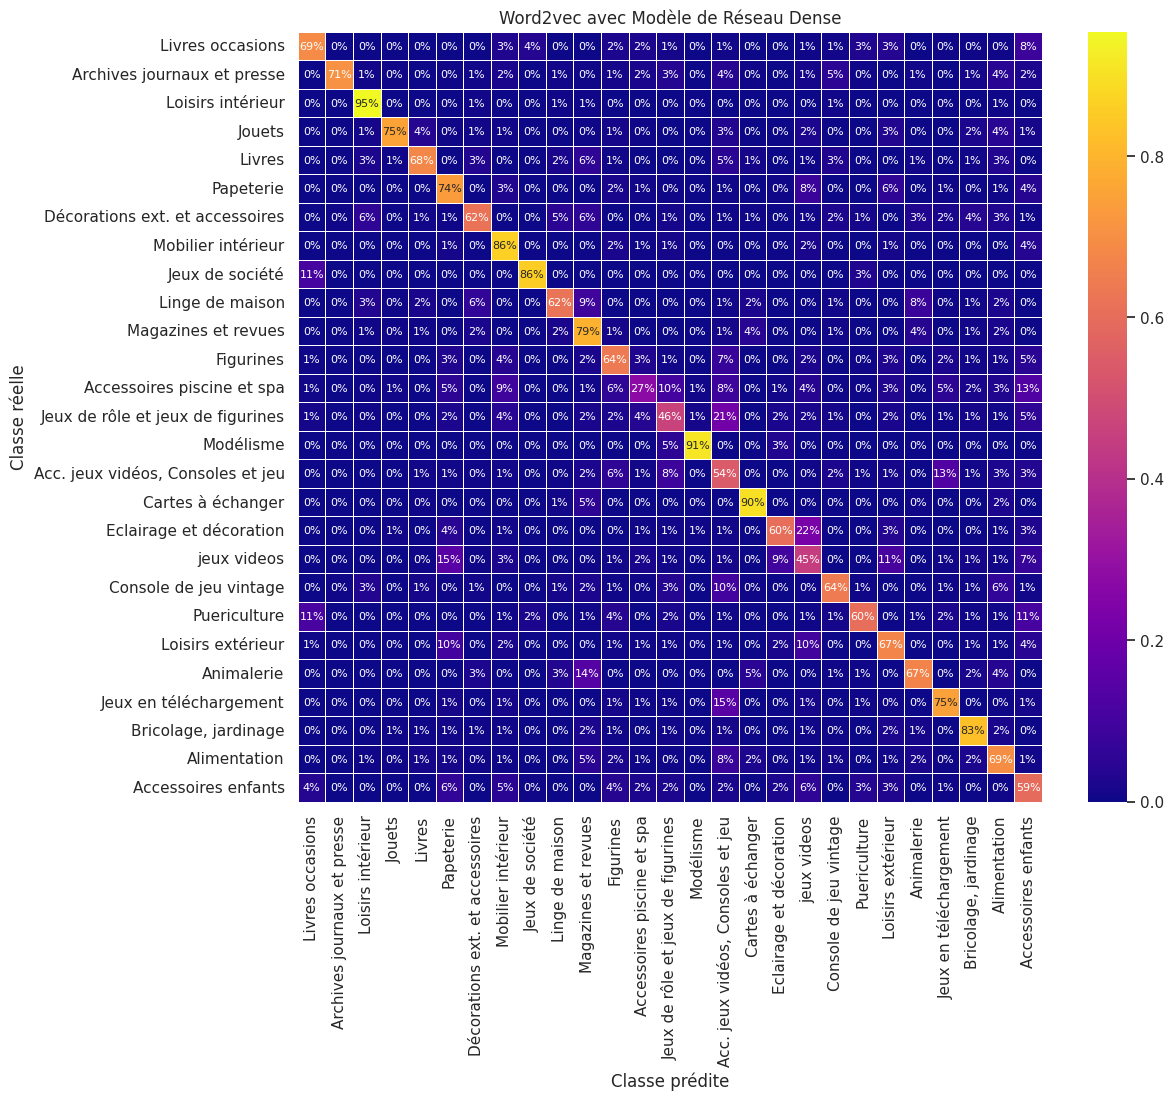

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
unique_categories = df['Labels'].drop_duplicates()

cm = confusion_matrix(y_test_labels,y_pred_class_labels)

# Normaliser la matrice de confusion
confusion_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.rcParams.update({'font.size': 8})
# Afficher la heatmap de la matrice de confusion
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_norm, annot=True, cmap=plt.cm.plasma, fmt=".0%", cbar_kws={"shrink": 1.0}, linewidth=.5, xticklabels=unique_categories, yticklabels=unique_categories)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Word2vec avec Modèle de Réseau Dense")
plt.show()

In [ ]:
# analyse des mauvaises prédictions
import itertools # Pour créer des iterateurs
print("Résultats des classes les plus mal prédites avec le réseau dense : ")
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if(confusion_norm[i,j]*100 >14 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(unique_categories.iloc[i], unique_categories.iloc[j]))

Résultats des classes les plus mal prédites avec le réseau dense : 
La classe Jeux de rôle et jeux de figurines a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu
La classe Eclairage et décoration a souvent été prise pour la classe jeux videos
La classe jeux videos a souvent été prise pour la classe Papeterie
La classe Animalerie a souvent été prise pour la classe Magazines et revues
La classe Jeux en téléchargement a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu


## *Essai CamemBERT avec TextCNN*

BERT (Bidirectional Encoder Representations from Transformers) : BERT est un modèle basé sur les transformers qui a révolutionné le domaine du traitement du langage naturel. Il est pré-entraîné sur de grandes quantités de texte non étiqueté, ce qui lui permet de capturer des représentations riches du langage. Nous avons utilisé sa version française CamemBERT. Ce modèle **ne passe pas l'étape de Pré traitement et de retrait des stop words**. Les stop words doivent en effet être conservés pour permettre l'analyse semanthique du modèle.
L'entrainement a été réalisé en le combinant avec le modèle TextCNN en version GPU gratuite sur google colab.


In [ ]:
df['Labels'].value_counts()

Accessoires piscine et spa           10209
Mobilier intérieur                    5073
Modélisme                             5045
Eclairage et décoration               4993
Papeterie                             4989
Jouets                                4870
Magazines et revues                   4774
Archives journaux et presse           4760
Linge de maison                       4303
Cartes à échanger                     3953
Puericulture                          3241
Livres occasions                      3116
Livres                                2761
Figurines                             2671
Décorations ext. et accessoires       2589
jeux videos                           2508
Bricolage, jardinage                  2496
Loisirs extérieur                     2491
Jeux de société                       2070
Loisirs intérieur                     1681
Acc. jeux vidéos, Consoles et jeu     1421
Jeux en téléchargement                 872
Console de jeu vintage                 832
Animalerie 

In [ ]:
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout

# Charger le tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Charger le modèle pré-entraîné
num_classes = 27
model = TFCamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=num_classes)

# Prétraitement des données
max_length = 300

# Encoder les données
descriptions = df['designe_decrit'].tolist()
labels = df['Labels'].tolist()

encoded_inputs = tokenizer(descriptions, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
input_ids = encoded_inputs['input_ids']

# Convertir les tenseurs EagerTensor en tableaux NumPy
input_ids = np.array(input_ids)
labels = np.array(labels)

# Diviser les données en ensembles d'entraînement et de test en conservant la répartition des classes
# train_input_ids, test_input_ids, train_labels, test_labels = train_test_split(
#     input_ids, labels, test_size=0.33, stratify=labels)

train_input_ids, test_input_ids, train_labels, test_labels = project_train_test_split(
    input_ids, labels, stratify=labels)

# train_input_ids et train_labels contiennent les données d'entraînement avec une répartition équilibrée des classes
# test_input_ids et test_labels contiennent les données de test avec une répartition équilibrée des classes

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Encoder les étiquettes en valeurs numériques
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Nombre d'input_ids :", len(input_ids))
print("Nombre de labels :", len(labels))

Nombre d'input_ids : 84916
Nombre de labels : 84916


In [ ]:
# Récupérer la couche d'embedding du modèle pré-entraîné
embedding_layer = model.get_input_embeddings()

# Récupérer la taille de l'embedding
embedding_size = model.config.hidden_size

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Pour éviter au maximum les fuites de mémoire, supprimer l'instance précédente de new_model si elle existe
# (cas où cette cellule serait exécutée plusieurs fois)
try:
  del new_model
except NameError:
  pass

# Ajouter une couche de convolution 1D avec plusieurs filtres de différentes tailles
filter_sizes = [3, 4, 5]    #test réalisé avec filter_sizes = [3, 4, 5]  & [5, 10, 15]
num_filters = [100, 200, 300]         #test réalisé sur [128,200,300]
batch_size=64
epochs=50

# Créer l'entrée du nouveau modèle
input_layer = Input(shape=(max_length,), dtype=tf.int32)

# Obtenir l'embedding des séquences d'entrée
embedded_sequences = embedding_layer(input_layer)

conv_layers = []
for filter_size in filter_sizes:
  for n_filters in num_filters:
    conv_layer = Conv1D(filters=n_filters, kernel_size=filter_size, activation='relu', kernel_initializer="normal")(embedded_sequences)
    dropout_layer_conv = Dropout(0.5)(conv_layer)
    pooled_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pooled_layer)

# Concaténer les caractéristiques extraites
concatenated_features = Concatenate()(conv_layers)

# Ajouter des couches de classification
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Ajouter une couche Dropout (tester : 0.2, 0.3, 0.4, 0.5)
dropout_layer = Dropout(0.5)(dense_layer)  # représente la fraction des unités d'entrée à exclure aléatoirement pendant l'entraînement

output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

# Créer un nouveau modèle avec la couche de classification modifiée
new_model = Model(inputs=input_layer, outputs=output_layer)

# Compiler le nouveau modèle
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entraîner le nouveau modèle
new_model.fit(
    train_input_ids,
    train_labels_encoded,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(test_input_ids, test_labels_encoded),
    callbacks=[
        ReduceLROnPlateau(monitor="val_loss", min_delta=0.01, patience=1, factor=0.5, cooldown=2),
        EarlyStopping(monitor="val_loss", min_delta=0.01, patience=4)
    ]
)


Epoch 1/50
889/889 [==============================] - 291s 309ms/step - loss: 2.5979 - accuracy: 0.2567 - val_loss: 1.7495 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 2/50
889/889 [==============================] - 270s 304ms/step - loss: 1.8285 - accuracy: 0.4587 - val_loss: 1.2549 - val_accuracy: 0.6883 - lr: 1.0000e-04
Epoch 3/50
889/889 [==============================] - 247s 278ms/step - loss: 1.5021 - accuracy: 0.5366 - val_loss: 0.9833 - val_accuracy: 0.7551 - lr: 1.0000e-04
Epoch 4/50
889/889 [==============================] - 241s 271ms/step - loss: 1.2980 - accuracy: 0.5864 - val_loss: 0.8453 - val_accuracy: 0.7769 - lr: 1.0000e-04
Epoch 5/50
889/889 [==============================] - 241s 271ms/step - loss: 1.1476 - accuracy: 0.6276 - val_loss: 0.7340 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 6/50
889/889 [==============================] - 241s 271ms/step - loss: 1.0373 - accuracy: 0.6527 - val_loss: 0.6771 - val_accuracy: 0.8159 - lr: 1.0000e-04
Epoch 7/50
889/889 [==

In [ ]:
#sauvegarde du modèle après entrainement

DIRECTORY = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten/models/saved_models"

model_path_tf = os.path.join(DIRECTORY, "model_trained_BERTCNN_tf_with_validation_data_2")
tf.saved_model.save(new_model, model_path_tf)

model_path_keras = os.path.join(DIRECTORY, "model_trained_BERTCNN_keras_with_validation_data_2")
new_model.save(model_path_keras)

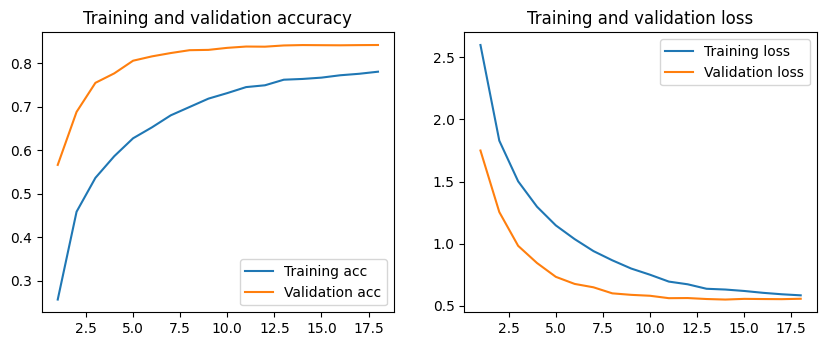

In [ ]:
# On évalue notre modèle en comparant les métriques, les courbes de loss et les courbes de précision

import matplotlib.pyplot as plt
import keras

acc = new_model.history.history['accuracy']
val_acc = new_model.history.history['val_accuracy']
loss = new_model.history.history['loss']
val_loss = new_model.history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Évaluer le modèle sur les données de test
results = new_model.evaluate(test_input_ids, test_labels_encoded)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

876/876 [==============================] - 30s 34ms/step - loss: 0.5578 - accuracy: 0.8421
Test loss: 0.5577705502510071
Test accuracy: 0.8420940041542053


In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Obtenir les prédictions
y_pred = new_model.predict(test_input_ids)

# Convertir les prédictions en classes prédites
y_pred_classes = np.argmax(y_pred, axis=1)

# récupération des labels
y_test_labels = label_encoder.inverse_transform(test_labels_encoded)
y_pred_class_labels = label_encoder.inverse_transform(y_pred_classes)


# Afficher le rapport de classification
print(classification_report(y_test_labels, y_pred_class_labels))


876/876 [==============================] - 28s 31ms/step
                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.83      0.75      0.79       469
              Accessoires enfants       0.99      0.86      0.92       266
       Accessoires piscine et spa       0.96      0.99      0.97      3369
                     Alimentation       0.97      0.80      0.87       265
                       Animalerie       0.98      0.67      0.79       272
      Archives journaux et presse       0.89      0.89      0.89      1571
             Bricolage, jardinage       0.90      0.87      0.88       824
                Cartes à échanger       0.96      0.94      0.95      1305
           Console de jeu vintage       1.00      0.81      0.89       275
  Décorations ext. et accessoires       0.84      0.74      0.78       854
          Eclairage et décoration       0.78      0.85      0.81      1648
                        Figurines       0.

In [ ]:
balanced_accuracy_score(y_test_labels, y_pred_class_labels)

0.7977476540963703

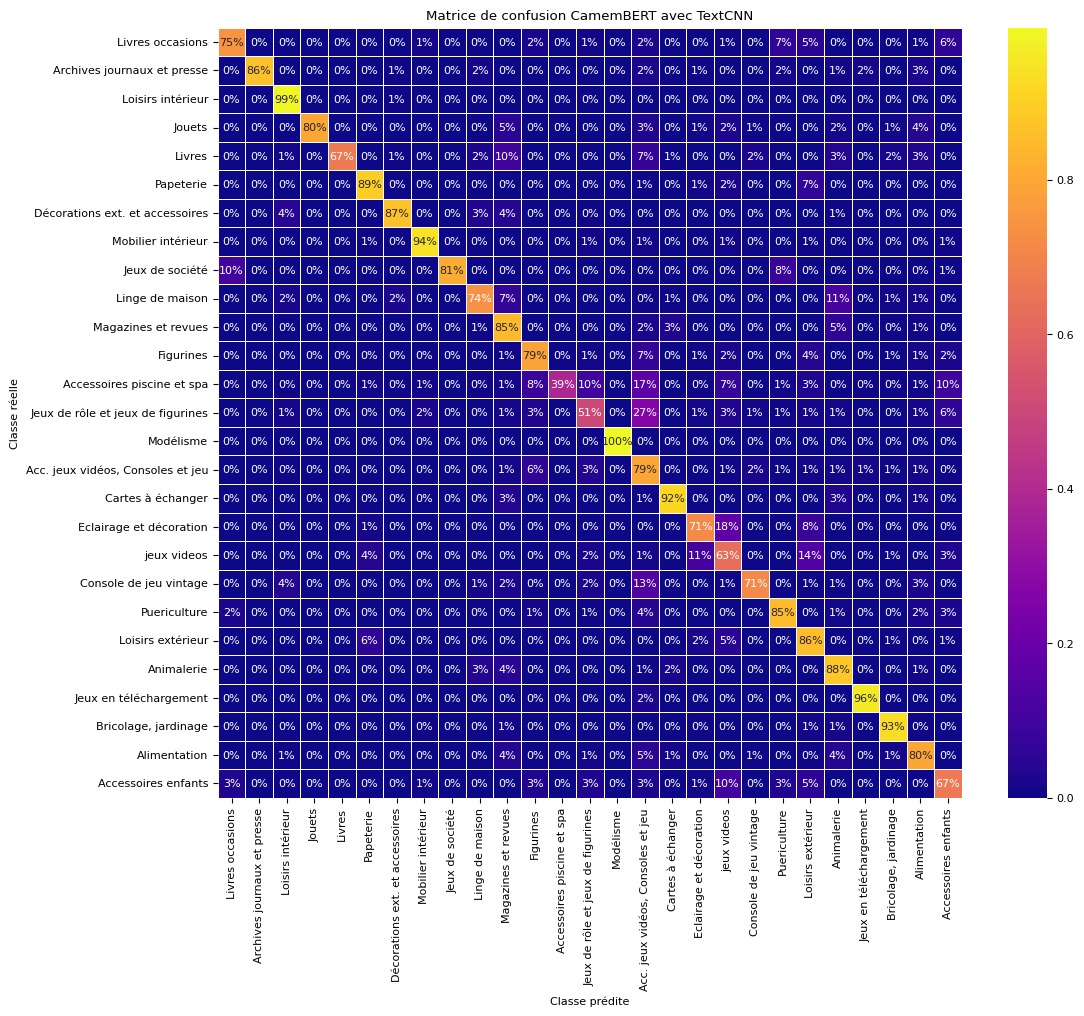

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
unique_categories = df['Labels'].drop_duplicates()
cm_bt = confusion_matrix(test_labels_encoded,y_pred_classes)

# Normaliser la matrice de confusion
confusion_norm_bt = cm_bt.astype('float') / cm_bt.sum(axis=1)[:, np.newaxis]
plt.rcParams.update({'font.size': 8})

# Afficher la heatmap de la matrice de confusion
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_norm_bt, annot=True, cmap=plt.cm.plasma, fmt=".0%", cbar_kws={"shrink": 1.0}, linewidth=.5, xticklabels=unique_categories, yticklabels=unique_categories)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion CamemBERT avec TextCNN")
plt.show()


In [ ]:
# analyse des mauvaises prédictions
import itertools # Pour créer des iterateurs
print("Résultats des classes les plus mal prédites avec CamemBERT : ")
for i, j in itertools.product(range(cm_bt.shape[0]), range(cm_bt.shape[1])):
    if(confusion_norm_bt[i,j]*100>14 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(unique_categories.iloc[i], unique_categories.iloc[j]))

Résultats des classes les plus mal prédites avec CamemBERT : 
La classe Accessoires piscine et spa a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu
La classe Jeux de rôle et jeux de figurines a souvent été prise pour la classe Acc. jeux vidéos, Consoles et jeu
La classe Eclairage et décoration a souvent été prise pour la classe jeux videos
La classe jeux videos a souvent été prise pour la classe Loisirs extérieur
